<a href="https://colab.research.google.com/github/visucs/100Day-of-ML/blob/main/web_scrape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

# Headers to mimic a real browser (avoids being blocked)
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/120.0.0.0 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
}

url = "https://www.fabvoguestudio.com/collections/digital-printed-fabrics?page=1"

response = requests.get(url, headers=headers)
print("Status Code:", response.status_code)

soup = BeautifulSoup(response.text, "lxml")

Status Code: 200


In [2]:
products = []

# Most Shopify stores use these common selectors
# Inspect the page and adjust if needed

product_cards = soup.select(".product-item, .grid__item, .product-card, li.grid__item")

print(f"Found {len(product_cards)} products")

for card in product_cards:
    try:
        # Product title
        title_el = card.select_one(".product-item__title, .card__heading, h3, h2")
        title = title_el.get_text(strip=True) if title_el else "N/A"

        # Price
        price_el = card.select_one(".price, .product-item__price, .price__regular")
        price = price_el.get_text(strip=True) if price_el else "N/A"

        # Product URL
        link_el = card.select_one("a[href*='/products/']")
        link = "https://www.fabvoguestudio.com" + link_el["href"] if link_el else "N/A"

        # Image URL
        img_el = card.select_one("img")
        image = img_el.get("src") or img_el.get("data-src") if img_el else "N/A"
        if image and image.startswith("//"):
            image = "https:" + image

        products.append({
            "Title": title,
            "Price": price,
            "URL": link,
            "Image": image
        })

    except Exception as e:
        print(f"Error parsing card: {e}")

# Show results
df = pd.DataFrame(products)
print(df.head(10))


Found 24 products
                                               Title     Price  \
0  Beautiful Floral Vine Over Brown Base Digital ...  ₹ 320.85   
1  Red And White Flower Digital Printed Fabric - ...  ₹ 331.20   
2  Glorry Beautiful Flower Digital Printed Fabric...  ₹ 331.20   
3  Tusser Silk Digital Printed Fabric in Beautifu...  ₹ 320.85   
4  Paisley Seamless over Black Digital Printed Fa...  ₹ 325.45   
5  Light Green Floral Digital Printed Viscose Org...  ₹ 573.85   
6  Pure Cotton Digital Printed Fabric - Peach Col...  ₹ 562.35   
7                  Blue Flower Velvet Printed Fabric  ₹ 573.85   
8          Blue Floral Pattern Velvet Printed Fabric  ₹ 573.85   
9  Gorgeous floral print digital printed fabric i...  ₹ 328.90   

                                                 URL  \
0  https://www.fabvoguestudio.com/en-us/products/...   
1  https://www.fabvoguestudio.com/en-us/products/...   
2  https://www.fabvoguestudio.com/en-us/products/...   
3  https://www.fabvoguestudio.c

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/120.0.0.0 Safari/537.36",
}

base_url = "https://www.fabvoguestudio.com/collections/digital-printed-fabrics?page={}"

all_products = []
page = 1

while True:
    url = base_url.format(page)
    print(f"Scraping page {page}...")

    response = requests.get(url, headers=headers)

    # Stop if page doesn't exist or redirects
    if response.status_code != 200:
        print(f"Stopped at page {page} — Status: {response.status_code}")
        break

    soup = BeautifulSoup(response.text, "lxml")
    product_cards = soup.select(".product-item, .grid__item, li.grid__item")

    # Stop if no products found (end of pages)
    if not product_cards:
        print(f"No products found on page {page}. Stopping.")
        break

    for card in product_cards:
        try:
            title_el = card.select_one(".product-item__title, .card__heading, h3, h2")
            title = title_el.get_text(strip=True) if title_el else "N/A"

            price_el = card.select_one(".price, .product-item__price")
            price = price_el.get_text(strip=True) if price_el else "N/A"

            link_el = card.select_one("a[href*='/products/']")
            link = "https://www.fabvoguestudio.com" + link_el["href"] if link_el else "N/A"

            img_el = card.select_one("img")
            image = img_el.get("src") or img_el.get("data-src") if img_el else "N/A"
            if image and image.startswith("//"):
                image = "https:" + image

            all_products.append({
                "Title": title,
                "Price": price,
                "URL": link,
                "Image": image,
                "Page": page
            })

        except Exception as e:
            print(f"Error: {e}")

    page += 1
    time.sleep(1.5)  # Be polite — don't hammer the server

print(f"\n✅ Total products scraped: {len(all_products)}")
df = pd.DataFrame(all_products)
df.head(20)

Scraping page 1...
No products found on page 1. Stopping.

✅ Total products scraped: 0


""


In [4]:
# Save to CSV
df.to_csv("fabvogue_products.csv", index=False)
print("Saved to fabvogue_products.csv")

# Save to Excel
df.to_excel("fabvogue_products.xlsx", index=False)
print("Saved to fabvogue_products.xlsx")

Saved to fabvogue_products.csv
Saved to fabvogue_products.xlsx


In [5]:
import requests
import pandas as pd

all_products = []
page = 1

while True:
    url = f"https://www.fabvoguestudio.com/collections/digital-printed-fabrics/products.json?limit=250&page={page}"

    response = requests.get(url)
    data = response.json()
    products = data.get("products", [])

    if not products:
        print(f"Done! Stopped at page {page}")
        break

    print(f"Page {page}: {len(products)} products")

    for p in products:
        all_products.append({
            "ID": p["id"],
            "Title": p["title"],
            "Vendor": p["vendor"],
            "Type": p["product_type"],
            "Tags": ", ".join(p["tags"]),
            "Price": p["variants"][0]["price"] if p["variants"] else "N/A",
            "URL": f"https://www.fabvoguestudio.com/products/{p['handle']}",
            "Image": p["images"][0]["src"] if p["images"] else "N/A",
            "Created": p["created_at"]
        })

    page += 1

df = pd.DataFrame(all_products)
print(f"\n✅ Total: {len(df)} products")
df.to_csv("fabvogue_all_products.csv", index=False)
df.head()

Page 1: 250 products
Page 2: 250 products
Page 3: 250 products
Page 4: 250 products
Page 5: 250 products
Page 6: 250 products
Page 7: 250 products
Page 8: 250 products
Page 9: 250 products
Page 10: 250 products
Page 11: 250 products
Page 12: 250 products
Page 13: 250 products
Page 14: 250 products
Page 15: 250 products
Page 16: 208 products
Done! Stopped at page 17

✅ Total: 3958 products


,ID,Title,Vendor,Type,Tags,Price,URL,Image,Created
0,6150548979905,Beautiful Floral Vine Over Brown Base Digital ...,FAB VOGUE Studio,Digital Printed Fabric,"brown, floral, FVs, NIS, polyester, tusser silk",279.00,https://www.fabvoguestudio.com/products/beauti...,https://cdn.shopify.com/s/files/1/0317/7598/16...,2020-12-13T19:21:25+05:30
1,6139780366529,Red And White Flower Digital Printed Fabric - ...,FAB VOGUE Studio,Digital Printed Fabric,"floral, FVs, NIS, polyester, red, weightless",288.00,https://www.fabvoguestudio.com/products/red-an...,https://cdn.shopify.com/s/files/1/0317/7598/16...,2020-12-06T20:33:10+05:30
2,6635996250305,Glorry Beautiful Flower Digital Printed Fabric...,FAB VOGUE Studio,Digital Printed Fabric,"blue, floral, FVs, gradient, NIS, polyester, S...",288.00,https://www.fabvoguestudio.com/products/glorry...,https://cdn.shopify.com/s/files/1/0317/7598/16...,2021-04-09T12:43:19+05:30
3,8002440593632,Tusser Silk Digital Printed Fabric in Beautifu...,FAB VOGUE Studio,Digital Printed Fabric,"ditsy, floral, FVs, green, NIS, polyester, red...",279.00,https://www.fabvoguestudio.com/products/tusser...,https://cdn.shopify.com/s/files/1/0317/7598/16...,2023-02-26T13:56:56+05:30
4,6150568673473,Paisley Seamless over Black Digital Printed Fa...,FAB VOGUE Studio,Digital Printed Fabric,"black, FVs, muslin, NIS, paisley, polyester",283.00,https://www.fabvoguestudio.com/products/paisle...,https://cdn.shopify.com/s/files/1/0317/7598/16...,2020-12-13T19:50:55+05:30


In [7]:
import requests
import pandas as pd

all_products = []
page = 1

while True:
    url = f"https://www.fabvoguestudio.com/collections/digital-printed-fabrics/products.json?limit=250&page={page}"

    response = requests.get(url)
    data = response.json()
    products = data.get("products", [])

    if not products:
        print(f"Done! Stopped at page {page}")
        break

    print(f"Page {page}: {len(products)} products")

    for p in products:
        # Get ALL images for each product
        images = p.get("images", [])

        # Fix image URL properly
        def fix_image_url(img_src):
            if not img_src:
                return "N/A"
            # Remove query params that break URL
            img_src = img_src.split("?")[0]
            # Fix protocol-relative URLs
            if img_src.startswith("//"):
                img_src = "https:" + img_src
            # Make sure https is there
            if not img_src.startswith("http"):
                img_src = "https:" + img_src
            return img_src

        main_image = fix_image_url(images[0]["src"]) if images else "N/A"

        all_products.append({
            "ID": p["id"],
            "Title": p["title"],
            "Vendor": p["vendor"],
            "Type": p["product_type"],
            "Tags": ", ".join(p["tags"]),
            "Price": p["variants"][0]["price"] if p["variants"] else "N/A",
            "URL": f"https://www.fabvoguestudio.com/products/{p['handle']}",
            "Image": main_image,
            "Created": p["created_at"]
        })

    page += 1

df = pd.DataFrame(all_products)
print(f"\n✅ Total: {len(df)} products")
df.to_csv("fabvogue_all_products 1.csv", index=False)

df.head()

Page 1: 250 products
Page 2: 250 products
Page 3: 250 products
Page 4: 250 products
Page 5: 250 products
Page 6: 250 products
Page 7: 250 products
Page 8: 250 products
Page 9: 250 products
Page 10: 250 products
Page 11: 250 products
Page 12: 250 products
Page 13: 250 products
Page 14: 250 products
Page 15: 250 products
Page 16: 208 products
Done! Stopped at page 17

✅ Total: 3958 products


,ID,Title,Vendor,Type,Tags,Price,URL,Image,Created
0,6150548979905,Beautiful Floral Vine Over Brown Base Digital ...,FAB VOGUE Studio,Digital Printed Fabric,"brown, floral, FVs, NIS, polyester, tusser silk",279.00,https://www.fabvoguestudio.com/products/beauti...,https://cdn.shopify.com/s/files/1/0317/7598/16...,2020-12-13T19:21:25+05:30
1,6139780366529,Red And White Flower Digital Printed Fabric - ...,FAB VOGUE Studio,Digital Printed Fabric,"floral, FVs, NIS, polyester, red, weightless",288.00,https://www.fabvoguestudio.com/products/red-an...,https://cdn.shopify.com/s/files/1/0317/7598/16...,2020-12-06T20:33:10+05:30
2,6635996250305,Glorry Beautiful Flower Digital Printed Fabric...,FAB VOGUE Studio,Digital Printed Fabric,"blue, floral, FVs, gradient, NIS, polyester, S...",288.00,https://www.fabvoguestudio.com/products/glorry...,https://cdn.shopify.com/s/files/1/0317/7598/16...,2021-04-09T12:43:19+05:30
3,8002440593632,Tusser Silk Digital Printed Fabric in Beautifu...,FAB VOGUE Studio,Digital Printed Fabric,"ditsy, floral, FVs, green, NIS, polyester, red...",279.00,https://www.fabvoguestudio.com/products/tusser...,https://cdn.shopify.com/s/files/1/0317/7598/16...,2023-02-26T13:56:56+05:30
4,6150568673473,Paisley Seamless over Black Digital Printed Fa...,FAB VOGUE Studio,Digital Printed Fabric,"black, FVs, muslin, NIS, paisley, polyester",283.00,https://www.fabvoguestudio.com/products/paisle...,https://cdn.shopify.com/s/files/1/0317/7598/16...,2020-12-13T19:50:55+05:30


In [9]:
import requests

all_prices = []
page = 1

while True:
    url = f"https://www.fabvoguestudio.com/collections/digital-printed-fabrics/products.json?limit=250&page={page}"

    response = requests.get(url)
    data = response.json()
    products = data.get("products", [])

    if not products:
        break

    for p in products:
        for variant in p["variants"]:
            price = float(variant["price"])
            all_prices.append(price)

    page += 1

total = sum(all_prices)
print(f"Total Products Variants : {len(all_prices)}")
print(f"Total Price (All)       : ₹{total:,.2f}")
print(f"Average Price           : ₹{total/len(all_prices):,.2f}")
print(f"Min Price               : ₹{min(all_prices):,.2f}")
print(f"Max Price               : ₹{max(all_prices):,.2f}")

Total Products Variants : 3960
Total Price (All)       : ₹1,456,700.00
Average Price           : ₹367.85
Min Price               : ₹271.00
Max Price               : ₹1,346.00


In [10]:
import requests

all_prices = []
page = 1

while True:
    url = f"https://www.fabvoguestudio.com/collections/digital-printed-fabrics/products.json?limit=250&page={page}"
    data = requests.get(url).json()
    products = data.get("products", [])
    if not products:
        break
    for p in products:
        for v in p["variants"]:
            all_prices.append(float(v["price"]))
    page += 1

print(f"💰 Total Price: ₹{sum(all_prices):,.2f}")

💰 Total Price: ₹1,456,700.00


In [11]:
import requests

all_products = []
page = 1

while True:
    url = f"https://www.fabvoguestudio.com/collections/digital-printed-fabrics/products.json?limit=250&page={page}"

    data = requests.get(url).json()
    products = data.get("products", [])

    if not products:
        break

    for p in products:
        all_products.append({
            "Title": p["title"],
            "Created": p["created_at"]
        })

    page += 1

# Date ke hisab se sort karo
from datetime import datetime

for p in all_products:
    p["Created"] = datetime.fromisoformat(p["Created"].replace("Z", "+00:00"))

# Sort by date
all_products.sort(key=lambda x: x["Created"])

# Sabse pehla aur sabse last
pehla   = all_products[0]
aakhri  = all_products[-1]

print(f"📦 Total Products     : {len(all_products)}")
print()
print(f"🟢 Sabse Pehla Product : {pehla['Title']}")
print(f"   Dala Gaya           : {pehla['Created'].strftime('%d %B %Y, %I:%M %p')}")
print()
print(f"🔴 Sabse Last Product  : {aakhri['Title']}")
print(f"   Dala Gaya           : {aakhri['Created'].strftime('%d %B %Y, %I:%M %p')}")


📦 Total Products     : 3958

🟢 Sabse Pehla Product : Beautiful Brown Floral Digital Printed Kota Doria Fabric
   Dala Gaya           : 11 July 2020, 05:07 PM

🔴 Sabse Last Product  : Beige & Red Watercolour Floral Printed Soft Rayon Fabric
   Dala Gaya           : 09 February 2026, 03:02 AM


In [12]:
import requests
import json
import pandas as pd
from datetime import datetime

# =====================
# STEP 1: SARA DATA FETCH KARO
# =====================

all_products = []
page = 1

print("⏳ Data fetch ho raha hai...")

while True:
    url = f"https://www.fabvoguestudio.com/collections/digital-printed-fabrics/products.json?limit=250&page={page}"

    response = requests.get(url)
    data = response.json()
    products = data.get("products", [])

    if not products:
        print(f"✅ Total Pages Scraped: {page-1}")
        break

    for p in products:
        # Image fix
        images = p.get("images", [])
        def fix_img(src):
            if not src: return "N/A"
            src = src.split("?")[0]
            if src.startswith("//"): src = "https:" + src
            return src

        main_image = fix_img(images[0]["src"]) if images else "N/A"
        all_images = [fix_img(img["src"]) for img in images]

        # Variants
        variants = []
        for v in p.get("variants", []):
            variants.append({
                "variant_id"    : v["id"],
                "title"         : v["title"],
                "price"         : v["price"],
                "compare_price" : v.get("compare_at_price", "N/A"),
                "sku"           : v.get("sku", "N/A"),
                "available"     : v.get("available", False),
                "weight"        : v.get("weight", "N/A"),
            })

        all_products.append({
            "id"           : p["id"],
            "title"        : p["title"],
            "vendor"       : p["vendor"],
            "product_type" : p["product_type"],
            "tags"         : p.get("tags", []),
            "price"        : p["variants"][0]["price"] if p["variants"] else "N/A",
            "compare_price": p["variants"][0].get("compare_at_price") if p["variants"] else "N/A",
            "url"          : f"https://www.fabvoguestudio.com/products/{p['handle']}",
            "main_image"   : main_image,
            "all_images"   : all_images,
            "variants"     : variants,
            "description"  : p.get("body_html", ""),
            "created_at"   : p.get("created_at", ""),
            "updated_at"   : p.get("updated_at", ""),
        })

    print(f"  Page {page}: {len(products)} products fetched")
    page += 1

print(f"\n✅ Total Products: {len(all_products)}")


# =====================
# STEP 2: JSON FILE SAVE KARO
# =====================

with open("fabvogue_products.json", "w", encoding="utf-8") as f:
    json.dump(all_products, f, ensure_ascii=False, indent=2)

print("💾 JSON saved: fabvogue_products.json")


# =====================
# STEP 3: HTML FILE SAVE KARO
# =====================

html_cards = ""
for p in all_products:
    tags_html = "".join([f'<span class="tag">{t}</span>' for t in p["tags"]])
    compare = f'<span class="compare">₹{p["compare_price"]}</span>' if p["compare_price"] else ""

    html_cards += f"""
    <div class="card">
        <div class="img-box">
            <img src="{p['main_image']}" alt="{p['title']}" onerror="this.src='https://via.placeholder.com/300x300?text=No+Image'"/>
        </div>
        <div class="info">
            <h3>{p['title']}</h3>
            <p class="vendor">🏷️ {p['vendor']}</p>
            <p class="type">📦 {p['product_type']}</p>
            <p class="price">💰 ₹{p['price']} {compare}</p>
            <div class="tags">{tags_html}</div>
            <a href="{p['url']}" target="_blank" class="btn">View Product →</a>
        </div>
    </div>
    """

html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8"/>
    <meta name="viewport" content="width=device-width, initial-scale=1.0"/>
    <title>FabVogue Studio — All Products</title>
    <style>
        * {{ margin:0; padding:0; box-sizing:border-box; }}
        body {{
            font-family: 'Segoe UI', sans-serif;
            background: #f5f5f5;
            color: #333;
        }}
        header {{
            background: linear-gradient(135deg, #1a1a2e, #16213e);
            color: white;
            padding: 30px 40px;
            text-align: center;
        }}
        header h1 {{ font-size: 32px; margin-bottom: 8px; }}
        header p  {{ color: #aaa; font-size: 15px; }}
        .stats {{
            display: flex;
            justify-content: center;
            gap: 40px;
            background: white;
            padding: 20px;
            border-bottom: 1px solid #eee;
            flex-wrap: wrap;
        }}
        .stat-box {{
            text-align: center;
        }}
        .stat-box h2 {{ font-size: 28px; color: #e63946; }}
        .stat-box p  {{ font-size: 13px; color: #888; }}

        /* Search Bar */
        .search-bar {{
            text-align: center;
            padding: 20px;
            background: white;
        }}
        .search-bar input {{
            width: 400px;
            padding: 10px 16px;
            border: 2px solid #ddd;
            border-radius: 30px;
            font-size: 15px;
            outline: none;
        }}
        .search-bar input:focus {{ border-color: #e63946; }}

        /* Grid */
        .grid {{
            display: grid;
            grid-template-columns: repeat(auto-fill, minmax(260px, 1fr));
            gap: 20px;
            padding: 30px 40px;
            max-width: 1400px;
            margin: 0 auto;
        }}
        .card {{
            background: white;
            border-radius: 12px;
            overflow: hidden;
            box-shadow: 0 2px 12px rgba(0,0,0,0.08);
            transition: transform 0.2s, box-shadow 0.2s;
        }}
        .card:hover {{
            transform: translateY(-4px);
            box-shadow: 0 8px 24px rgba(0,0,0,0.14);
        }}
        .img-box {{
            width: 100%;
            height: 220px;
            overflow: hidden;
            background: #f9f9f9;
        }}
        .img-box img {{
            width: 100%;
            height: 100%;
            object-fit: cover;
            transition: transform 0.3s;
        }}
        .card:hover .img-box img {{ transform: scale(1.05); }}
        .info {{ padding: 14px 16px 18px; }}
        .info h3 {{
            font-size: 14px;
            font-weight: 600;
            margin-bottom: 8px;
            line-height: 1.4;
            height: 40px;
            overflow: hidden;
        }}
        .vendor, .type {{
            font-size: 12px;
            color: #888;
            margin-bottom: 4px;
        }}
        .price {{
            font-size: 16px;
            font-weight: 700;
            color: #e63946;
            margin: 8px 0;
        }}
        .compare {{
            font-size: 13px;
            color: #aaa;
            text-decoration: line-through;
            margin-left: 6px;
            font-weight: 400;
        }}
        .tags {{ margin: 8px 0; display: flex; flex-wrap: wrap; gap: 4px; }}
        .tag {{
            background: #f0f0f0;
            color: #555;
            font-size: 10px;
            padding: 2px 8px;
            border-radius: 20px;
        }}
        .btn {{
            display: inline-block;
            margin-top: 10px;
            padding: 8px 16px;
            background: #1a1a2e;
            color: white;
            border-radius: 6px;
            font-size: 13px;
            text-decoration: none;
            transition: background 0.2s;
        }}
        .btn:hover {{ background: #e63946; }}
        footer {{
            text-align: center;
            padding: 30px;
            color: #aaa;
            font-size: 13px;
            border-top: 1px solid #eee;
            margin-top: 20px;
        }}
    </style>
</head>
<body>

<header>
    <h1>🧵 FabVogue Studio</h1>
    <p>Digital Printed Fabrics — Complete Product Catalog</p>
    <p style="margin-top:6px; font-size:13px; color:#ccc;">
        Scraped on: {datetime.now().strftime('%d %B %Y, %I:%M %p')}
    </p>
</header>

<div class="stats">
    <div class="stat-box">
        <h2>{len(all_products)}</h2>
        <p>Total Products</p>
    </div>
    <div class="stat-box">
        <h2>₹{sum(float(p['price']) for p in all_products if p['price'] != 'N/A'):,.0f}</h2>
        <p>Total Catalog Value</p>
    </div>
    <div class="stat-box">
        <h2>₹{sum(float(p['price']) for p in all_products if p['price'] != 'N/A') / len(all_products):,.0f}</h2>
        <p>Average Price</p>
    </div>
</div>

<div class="search-bar">
    <input type="text" id="searchInput"
           placeholder="🔍 Search products..."
           onkeyup="searchProducts()"/>
</div>

<div class="grid" id="productGrid">
    {html_cards}
</div>

<footer>
    © FabVogue Studio | Data scraped for educational purposes only
</footer>

<script>
function searchProducts() {{
    const input = document.getElementById('searchInput').value.toLowerCase();
    const cards = document.querySelectorAll('.card');
    cards.forEach(card => {{
        const title = card.querySelector('h3').textContent.toLowerCase();
        card.style.display = title.includes(input) ? 'block' : 'none';
    }});
}}
</script>

</body>
</html>
"""

with open("fabvogue_products.html", "w", encoding="utf-8") as f:
    f.write(html_content)

print("🌐 HTML saved: fabvogue_products.html")
print("\n🎉 Done! Dono files ready hain:")
print("   📄 fabvogue_products.json")
print("   🌐 fabvogue_products.html")


⏳ Data fetch ho raha hai...
  Page 1: 250 products fetched
  Page 2: 250 products fetched
  Page 3: 250 products fetched
  Page 4: 250 products fetched
  Page 5: 250 products fetched
  Page 6: 250 products fetched
  Page 7: 250 products fetched
  Page 8: 250 products fetched
  Page 9: 250 products fetched
  Page 10: 250 products fetched
  Page 11: 250 products fetched
  Page 12: 250 products fetched
  Page 13: 250 products fetched
  Page 14: 250 products fetched
  Page 15: 250 products fetched
  Page 16: 208 products fetched
✅ Total Pages Scraped: 16

✅ Total Products: 3958
💾 JSON saved: fabvogue_products.json
🌐 HTML saved: fabvogue_products.html

🎉 Done! Dono files ready hain:
   📄 fabvogue_products.json
   🌐 fabvogue_products.html


In [14]:
import requests
import json
from datetime import datetime

# =====================
# STEP 1: DATA FETCH
# =====================
all_products = []
page = 1

print("⏳ FabVogue data fetch ho raha hai...")

while True:
    url = f"https://www.fabvoguestudio.com/collections/digital-printed-fabrics/products.json?limit=250&page={page}"
    response = requests.get(url)
    data = response.json()
    products = data.get("products", [])

    if not products:
        break

    for p in products:
        images = p.get("images", [])
        def fix_img(src):
            if not src: return "https://via.placeholder.com/300x300?text=No+Image"
            src = src.split("?")[0]
            if src.startswith("//"): src = "https:" + src
            return src

        main_image = fix_img(images[0]["src"]) if images else "https://via.placeholder.com/300x300?text=No+Image"
        price = float(p["variants"][0]["price"]) if p["variants"] else 0
        compare = float(p["variants"][0]["compare_at_price"]) if p["variants"] and p["variants"][0].get("compare_at_price") else 0
        discount = round(((compare - price) / compare) * 100) if compare > price else 0
        tags = p.get("tags", [])
        product_type = p.get("product_type", "Fabric")

        all_products.append({
            "id":           p["id"],
            "title":        p["title"],
            "price":        price,
            "compare":      compare,
            "discount":     discount,
            "type":         product_type,
            "tags":         tags,
            "image":        main_image,
            "url":          f"https://www.fabvoguestudio.com/products/{p['handle']}",
            "vendor":       p.get("vendor", "FabVogue Studio"),
            "created_at":   p.get("created_at", ""),
        })

    print(f"  Page {page}: {len(products)} products")
    page += 1

print(f"✅ Total: {len(all_products)} products")

# =====================
# STEP 2: GET UNIQUE TYPES & TAGS FOR FILTERS
# =====================
all_types = sorted(set(p["type"] for p in all_products if p["type"]))
all_tags  = sorted(set(tag for p in all_products for tag in p["tags"]))[:20]
prices    = [p["price"] for p in all_products if p["price"] > 0]
min_price = int(min(prices)) if prices else 0
max_price = int(max(prices)) if prices else 5000

# =====================
# STEP 3: BUILD HTML
# =====================
products_json = json.dumps(all_products, ensure_ascii=False)

type_options = "\n".join([f'<option value="{t}">{t}</option>' for t in all_types if t])
tag_checkboxes = "\n".join([
    f'<label class="tag-cb"><input type="checkbox" value="{tag}" onchange="applyFilters()"> {tag}</label>'
    for tag in all_tags
])

html = f"""<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8"/>
  <meta name="viewport" content="width=device-width, initial-scale=1.0"/>
  <title>FabVogue Studio — Digital Printed Fabrics</title>
  <link href="https://fonts.googleapis.com/css2?family=DM+Sans:wght@400;500;600;700&display=swap" rel="stylesheet"/>
  <style>
    :root {{
      --primary: #c0392b;
      --primary-dark: #96281b;
      --yellow: #f39c12;
      --green: #27ae60;
      --bg: #f7f7f7;
      --white: #ffffff;
      --border: #e0e0e0;
      --text: #222;
      --muted: #888;
      --sidebar: 260px;
    }}
    * {{ margin:0; padding:0; box-sizing:border-box; }}
    body {{ font-family:'DM Sans',sans-serif; background:var(--bg); color:var(--text); }}

    /* ── HEADER ── */
    header {{
      background: var(--primary);
      padding: 0 28px;
      height: 60px;
      display: flex;
      align-items: center;
      justify-content: space-between;
      position: sticky; top:0; z-index:100;
      box-shadow: 0 2px 10px rgba(0,0,0,0.2);
    }}
    .logo {{ color:white; font-size:20px; font-weight:700; letter-spacing:-0.3px; }}
    .logo span {{ color:#ffe082; font-size:12px; font-weight:400; margin-left:6px; }}
    .header-right {{ display:flex; align-items:center; gap:12px; }}
    .header-search {{
      display: flex;
      align-items: center;
      background: white;
      border-radius: 4px;
      overflow: hidden;
      width: 280px;
    }}
    .header-search input {{
      border:none; outline:none;
      padding: 8px 12px;
      font-size: 14px;
      width: 100%;
      font-family: inherit;
    }}
    .header-search button {{
      background: var(--yellow);
      border: none;
      padding: 8px 14px;
      cursor: pointer;
      font-size: 16px;
    }}
    .cart-btn {{
      background: var(--yellow);
      color: white;
      border: none;
      padding: 9px 18px;
      border-radius: 4px;
      font-weight: 600;
      font-size: 14px;
      cursor: pointer;
      display: flex; align-items:center; gap:8px;
      transition: background 0.2s;
      font-family: inherit;
    }}
    .cart-btn:hover {{ background: #d68910; }}
    .cart-count {{
      background: white; color: var(--primary);
      border-radius: 50%;
      width:20px; height:20px;
      font-size:11px; font-weight:700;
      display:flex; align-items:center; justify-content:center;
    }}

    /* ── LAYOUT ── */
    .layout {{ display:flex; min-height:calc(100vh - 60px); }}

    /* ── SIDEBAR FILTER ── */
    .sidebar {{
      width: var(--sidebar);
      background: white;
      border-right: 1px solid var(--border);
      padding: 20px 16px;
      position: sticky;
      top: 60px;
      height: calc(100vh - 60px);
      overflow-y: auto;
      flex-shrink: 0;
    }}
    .sidebar h3 {{
      font-size: 13px;
      font-weight: 700;
      text-transform: uppercase;
      letter-spacing: 0.8px;
      color: var(--muted);
      margin-bottom: 14px;
      padding-bottom: 8px;
      border-bottom: 2px solid var(--primary);
    }}
    .filter-section {{ margin-bottom: 24px; }}
    .filter-section h4 {{
      font-size: 14px; font-weight: 600;
      margin-bottom: 10px; color: var(--text);
    }}
    .sidebar select {{
      width: 100%;
      padding: 8px 10px;
      border: 1px solid var(--border);
      border-radius: 4px;
      font-size: 13px;
      font-family: inherit;
      outline: none;
      cursor: pointer;
    }}
    .sidebar select:focus {{ border-color: var(--primary); }}
    .price-range {{ display:flex; flex-direction:column; gap:8px; }}
    .price-range input[type=range] {{
      width: 100%;
      accent-color: var(--primary);
    }}
    .price-labels {{ display:flex; justify-content:space-between; font-size:12px; color:var(--muted); }}
    .price-value {{ font-weight:600; color:var(--primary); font-size:13px; }}
    .sort-select {{
      width: 100%;
      padding: 8px 10px;
      border: 1px solid var(--border);
      border-radius: 4px;
      font-size: 13px;
      font-family: inherit;
      outline: none;
    }}
    .tag-cb {{
      display: flex;
      align-items: center;
      gap: 6px;
      font-size: 13px;
      padding: 4px 0;
      cursor: pointer;
    }}
    .tag-cb input {{ accent-color: var(--primary); cursor:pointer; }}
    .clear-btn {{
      width: 100%;
      padding: 9px;
      background: #fef3f2;
      color: var(--primary);
      border: 1px solid var(--primary);
      border-radius: 4px;
      font-weight: 600;
      font-size: 13px;
      cursor: pointer;
      font-family: inherit;
      transition: all 0.2s;
      margin-top: 8px;
    }}
    .clear-btn:hover {{ background: var(--primary); color: white; }}

    /* ── MAIN CONTENT ── */
    .main {{ flex:1; padding: 20px 24px; }}
    .results-bar {{
      display: flex;
      justify-content: space-between;
      align-items: center;
      margin-bottom: 16px;
      padding: 10px 14px;
      background: white;
      border-radius: 6px;
      border: 1px solid var(--border);
    }}
    .results-bar span {{ font-size: 14px; color: var(--muted); }}
    .results-bar strong {{ color: var(--text); }}

    /* ── PRODUCT GRID ── */
    .grid {{
      display: grid;
      grid-template-columns: repeat(auto-fill, minmax(210px, 1fr));
      gap: 16px;
    }}
    .card {{
      background: white;
      border-radius: 8px;
      overflow: hidden;
      border: 1px solid var(--border);
      transition: box-shadow 0.2s, transform 0.2s;
      position: relative;
      display: flex;
      flex-direction: column;
    }}
    .card:hover {{
      box-shadow: 0 6px 24px rgba(0,0,0,0.12);
      transform: translateY(-3px);
    }}
    .discount-badge {{
      position: absolute;
      top: 10px; left: 10px;
      background: var(--green);
      color: white;
      font-size: 11px; font-weight:700;
      padding: 3px 8px;
      border-radius: 3px;
      z-index: 1;
    }}
    .wishlist-btn {{
      position: absolute;
      top: 8px; right: 8px;
      background: white;
      border: 1px solid var(--border);
      border-radius: 50%;
      width: 32px; height:32px;
      font-size: 16px;
      cursor: pointer;
      display: flex; align-items:center; justify-content:center;
      transition: all 0.2s;
      z-index: 1;
    }}
    .wishlist-btn:hover {{ background: #fff0f0; border-color: var(--primary); }}
    .wishlist-btn.active {{ color: var(--primary); background: #fff0f0; }}
    .img-box {{
      height: 200px;
      background: #f9f9f9;
      display: flex; align-items:center; justify-content:center;
      overflow: hidden;
      padding: 8px;
    }}
    .img-box img {{
      max-height: 184px; max-width: 100%;
      object-fit: contain;
      transition: transform 0.3s;
    }}
    .card:hover .img-box img {{ transform: scale(1.06); }}
    .info {{ padding: 12px; flex:1; display:flex; flex-direction:column; }}
    .info h3 {{
      font-size: 13px; font-weight:500;
      line-height: 1.4;
      height: 36px; overflow:hidden;
      margin-bottom: 8px;
      color: var(--text);
    }}
    .price-row {{ display:flex; align-items:center; gap:8px; margin-bottom:10px; }}
    .price {{ font-size:16px; font-weight:700; color:var(--text); }}
    .compare {{ font-size:12px; color:var(--muted); text-decoration:line-through; }}
    .type-badge {{
      display: inline-block;
      font-size: 10px; font-weight:600;
      padding: 2px 8px;
      border-radius: 20px;
      background: #fef3e2;
      color: #b7580a;
      margin-bottom: 10px;
    }}
    .card-actions {{ display:flex; gap:8px; margin-top:auto; }}
    .add-cart-btn {{
      flex: 1;
      padding: 9px 6px;
      background: var(--primary);
      color: white;
      border: none;
      border-radius: 4px;
      font-size: 12px; font-weight:600;
      cursor: pointer;
      font-family: inherit;
      transition: background 0.2s;
    }}
    .add-cart-btn:hover {{ background: var(--primary-dark); }}
    .add-cart-btn.added {{
      background: var(--green);
    }}
    .buy-btn {{
      flex: 1;
      padding: 9px 6px;
      background: var(--yellow);
      color: white;
      border: none;
      border-radius: 4px;
      font-size: 12px; font-weight:600;
      cursor: pointer;
      font-family: inherit;
      text-decoration: none;
      display: flex; align-items:center; justify-content:center;
      transition: background 0.2s;
    }}
    .buy-btn:hover {{ background: #d68910; }}

    /* ── CART OVERLAY ── */
    .cart-overlay {{
      display:none;
      position:fixed; inset:0;
      background:rgba(0,0,0,0.5);
      z-index:200;
    }}
    .cart-overlay.open {{ display:block; }}
    .cart-sidebar {{
      position:fixed;
      right:-430px; top:0; bottom:0;
      width:400px;
      background:white;
      z-index:201;
      transition:right 0.3s ease;
      display:flex; flex-direction:column;
      box-shadow:-4px 0 20px rgba(0,0,0,0.2);
    }}
    .cart-sidebar.open {{ right:0; }}
    .cart-head {{
      background:var(--primary);
      color:white;
      padding:16px 20px;
      display:flex; justify-content:space-between; align-items:center;
    }}
    .cart-head h2 {{ font-size:17px; font-weight:600; }}
    .close-cart {{
      background:none; border:none;
      color:white; font-size:26px;
      cursor:pointer; line-height:1;
    }}
    .cart-items {{ flex:1; overflow-y:auto; padding:12px; }}
    .empty-cart {{
      text-align:center; padding:40px 20px; color:var(--muted);
    }}
    .empty-cart .icon {{ font-size:48px; margin-bottom:12px; }}
    .cart-item {{
      display:flex; gap:12px;
      padding:12px;
      border:1px solid var(--border);
      border-radius:8px;
      margin-bottom:10px;
      background:#fafafa;
      animation:slideIn 0.2s ease;
    }}
    @keyframes slideIn {{
      from {{ opacity:0; transform:translateX(20px); }}
      to   {{ opacity:1; transform:translateX(0); }}
    }}
    .cart-item img {{
      width:70px; height:70px;
      object-fit:contain;
      background:white;
      border-radius:6px;
      border:1px solid var(--border);
    }}
    .cart-item-info {{ flex:1; }}
    .cart-item-info h4 {{ font-size:13px; font-weight:500; line-height:1.4; margin-bottom:6px; }}
    .item-price {{ color:var(--primary); font-weight:700; font-size:15px; }}
    .qty-controls {{ display:flex; align-items:center; gap:8px; margin-top:8px; }}
    .qty-btn {{
      width:28px; height:28px;
      border:1px solid var(--border);
      background:white; border-radius:4px;
      font-size:16px; font-weight:600;
      cursor:pointer; display:flex;
      align-items:center; justify-content:center;
      transition:background 0.15s;
    }}
    .qty-btn:hover {{ background:var(--bg); }}
    .qty-num {{ font-weight:600; font-size:14px; min-width:22px; text-align:center; }}
    .remove-item {{
      background:none; border:none;
      color:var(--muted); font-size:18px;
      cursor:pointer; padding:4px;
      align-self:flex-start;
    }}
    .remove-item:hover {{ color:var(--primary); }}
    .cart-footer {{
      padding:16px 20px;
      border-top:1px solid var(--border);
      background:white;
    }}
    .cart-total {{
      display:flex; justify-content:space-between;
      font-size:16px; font-weight:700;
      margin-bottom:14px;
    }}
    .checkout-btn {{
      width:100%;
      padding:12px;
      background:var(--yellow);
      color:white; border:none;
      border-radius:4px;
      font-size:15px; font-weight:700;
      cursor:pointer; font-family:inherit;
      transition:background 0.2s;
    }}
    .checkout-btn:hover {{ background:#d68910; }}

    /* ── TOAST ── */
    .toast {{
      position:fixed; bottom:24px; left:50%;
      transform:translateX(-50%) translateY(80px);
      background:#222; color:white;
      padding:12px 24px; border-radius:24px;
      font-size:14px; font-weight:500;
      z-index:999; transition:transform 0.3s ease;
      pointer-events:none;
    }}
    .toast.show {{ transform:translateX(-50%) translateY(0); }}

    /* ── STATS ── */
    .stats-bar {{
      background:white;
      border-bottom:1px solid var(--border);
      padding:12px 24px;
      display:flex; gap:32px; flex-wrap:wrap;
    }}
    .stat {{ text-align:center; }}
    .stat h2 {{ font-size:22px; font-weight:700; color:var(--primary); }}
    .stat p  {{ font-size:12px; color:var(--muted); }}

    /* ── NO RESULTS ── */
    .no-results {{
      text-align:center; padding:60px 20px;
      color:var(--muted); grid-column:1/-1;
    }}
    .no-results .icon {{ font-size:48px; margin-bottom:12px; }}

    /* SCROLLBAR */
    ::-webkit-scrollbar {{ width:6px; }}
    ::-webkit-scrollbar-track {{ background:#f1f1f1; }}
    ::-webkit-scrollbar-thumb {{ background:#ccc; border-radius:3px; }}
  </style>
</head>
<body>

<!-- HEADER -->
<header>
  <div class="logo">🧵 FabVogue Studio <span>Digital Printed Fabrics</span></div>
  <div class="header-right">
    <div class="header-search">
      <input type="text" id="headerSearch" placeholder="Search fabrics..." oninput="applyFilters()"/>
      <button>🔍</button>
    </div>
    <button class="cart-btn" onclick="toggleCart()">
      🛒 Cart
      <span class="cart-count" id="cartCount">0</span>
    </button>
  </div>
</header>

<!-- STATS -->
<div class="stats-bar" id="statsBar"></div>

<!-- LAYOUT -->
<div class="layout">

  <!-- SIDEBAR FILTER -->
  <aside class="sidebar">
    <h3>🔍 Filters</h3>

    <div class="filter-section">
      <h4>Product Type</h4>
      <select id="filterType" onchange="applyFilters()">
        <option value="">All Types</option>
        {type_options}
      </select>
    </div>

    <div class="filter-section">
      <h4>Price Range</h4>
      <div class="price-range">
        <div style="display:flex;justify-content:space-between;align-items:center;">
          <span style="font-size:12px;color:var(--muted)">₹{min_price}</span>
          <span class="price-value" id="priceVal">₹{max_price}</span>
          <span style="font-size:12px;color:var(--muted)">₹{max_price}</span>
        </div>
        <input type="range" id="filterPrice"
               min="{min_price}" max="{max_price}" value="{max_price}" step="10"
               oninput="document.getElementById('priceVal').textContent='₹'+this.value; applyFilters()"/>
      </div>
    </div>

    <div class="filter-section">
      <h4>Discount</h4>
      <select id="filterDiscount" onchange="applyFilters()">
        <option value="0">All Products</option>
        <option value="10">10% or more</option>
        <option value="20">20% or more</option>
        <option value="30">30% or more</option>
        <option value="50">50% or more</option>
      </select>
    </div>

    <div class="filter-section">
      <h4>Sort By</h4>
      <select id="sortBy" onchange="applyFilters()">
        <option value="default">Default</option>
        <option value="price_low">Price: Low to High</option>
        <option value="price_high">Price: High to Low</option>
        <option value="discount">Highest Discount</option>
        <option value="newest">Newest First</option>
        <option value="name_az">Name: A to Z</option>
      </select>
    </div>

    <div class="filter-section">
      <h4>Tags</h4>
      <div id="tagFilters">{tag_checkboxes}</div>
    </div>

    <button class="clear-btn" onclick="clearFilters()">✕ Clear All Filters</button>
  </aside>

  <!-- MAIN -->
  <main class="main">
    <div class="results-bar">
      <span>Showing <strong id="resultCount">0</strong> products</span>
      <span id="activeFiltersText" style="color:var(--primary);font-size:13px;"></span>
    </div>
    <div class="grid" id="productGrid"></div>
  </main>
</div>

<!-- CART SIDEBAR -->
<div class="cart-overlay" id="cartOverlay" onclick="toggleCart()"></div>
<div class="cart-sidebar" id="cartSidebar">
  <div class="cart-head">
    <h2>🛒 My Cart (<span id="cartItemCount">0</span> items)</h2>
    <button class="close-cart" onclick="toggleCart()">×</button>
  </div>
  <div class="cart-items" id="cartItems">
    <div class="empty-cart">
      <div class="icon">🛒</div>
      <p>Your cart is empty</p>
      <p style="font-size:13px;margin-top:6px;">Add some fabrics!</p>
    </div>
  </div>
  <div class="cart-footer">
    <div class="cart-total">
      <span>Total:</span>
      <span id="cartTotal">₹0.00</span>
    </div>
    <button class="checkout-btn" onclick="checkout()">
      Proceed to Checkout →
    </button>
  </div>
</div>

<!-- TOAST -->
<div class="toast" id="toast"></div>

<script>
// ── ALL PRODUCTS DATA ──
const ALL_PRODUCTS = {products_json};

let cart = {{}};

// ── RENDER STATS ──
function renderStats() {{
  const prices = ALL_PRODUCTS.map(p => p.price).filter(x => x > 0);
  const total  = prices.reduce((a,b) => a+b, 0);
  const avg    = total / prices.length;
  document.getElementById('statsBar').innerHTML = `
    <div class="stat"><h2>${{ALL_PRODUCTS.length}}</h2><p>Total Products</p></div>
    <div class="stat"><h2>₹${{Math.min(...prices).toLocaleString('en-IN')}}</h2><p>Min Price</p></div>
    <div class="stat"><h2>₹${{Math.round(avg).toLocaleString('en-IN')}}</h2><p>Avg Price</p></div>
    <div class="stat"><h2>₹${{Math.max(...prices).toLocaleString('en-IN')}}</h2><p>Max Price</p></div>
  `;
}}

// ── APPLY FILTERS ──
function applyFilters() {{
  const search   = document.getElementById('headerSearch').value.toLowerCase();
  const type     = document.getElementById('filterType').value;
  const maxPrice = parseFloat(document.getElementById('filterPrice').value);
  const discount = parseInt(document.getElementById('filterDiscount').value);
  const sortBy   = document.getElementById('sortBy').value;
  const checkedTags = [...document.querySelectorAll('#tagFilters input:checked')].map(el => el.value);

  let filtered = ALL_PRODUCTS.filter(p => {{
    if (search && !p.title.toLowerCase().includes(search)) return false;
    if (type   && p.type !== type) return false;
    if (p.price > maxPrice) return false;
    if (discount > 0 && p.discount < discount) return false;
    if (checkedTags.length > 0 && !checkedTags.some(t => p.tags.includes(t))) return false;
    return true;
  }});

  // Sort
  if (sortBy === 'price_low')  filtered.sort((a,b) => a.price - b.price);
  if (sortBy === 'price_high') filtered.sort((a,b) => b.price - a.price);
  if (sortBy === 'discount')   filtered.sort((a,b) => b.discount - a.discount);
  if (sortBy === 'newest')     filtered.sort((a,b) => new Date(b.created_at) - new Date(a.created_at));
  if (sortBy === 'name_az')    filtered.sort((a,b) => a.title.localeCompare(b.title));

  document.getElementById('resultCount').textContent = filtered.length;

  // Active filters text
  let activeFilters = [];
  if (search)         activeFilters.push(`"${{search}}"`);
  if (type)           activeFilters.push(type);
  if (discount > 0)   activeFilters.push(`${{discount}}%+ off`);
  if (checkedTags.length) activeFilters.push(checkedTags.join(', '));
  document.getElementById('activeFiltersText').textContent =
    activeFilters.length ? `Filters: ${{activeFilters.join(' · ')}}` : '';

  renderGrid(filtered);
}}

// ── RENDER GRID ──
function renderGrid(products) {{
  const grid = document.getElementById('productGrid');
  if (products.length === 0) {{
    grid.innerHTML = `
      <div class="no-results">
        <div class="icon">😕</div>
        <p style="font-size:16px;font-weight:600;">Koi product nahi mila</p>
        <p style="font-size:13px;margin-top:6px;">Filters change karo ya clear karo</p>
      </div>`;
    return;
  }}

  grid.innerHTML = products.map(p => {{
    const discBadge = p.discount > 0
      ? `<span class="discount-badge">${{p.discount}}% OFF</span>` : '';
    const comparePrice = p.compare > 0
      ? `<span class="compare">₹${{p.compare.toLocaleString('en-IN')}}</span>` : '';
    const inCart = cart[p.id] ? cart[p.id].qty : 0;

    return `
    <div class="card" id="card-${{p.id}}">
      ${{discBadge}}
      <button class="wishlist-btn" id="wish-${{p.id}}" onclick="toggleWishlist(${{p.id}}, this)">🤍</button>
      <div class="img-box">
        <img src="${{p.image}}"
             alt="${{p.title}}"
             onerror="this.src='https://via.placeholder.com/300x300?text=No+Image'"/>
      </div>
      <div class="info">
        <h3>${{p.title}}</h3>
        <span class="type-badge">${{p.type || 'Fabric'}}</span>
        <div class="price-row">
          <span class="price">₹${{p.price.toLocaleString('en-IN')}}</span>
          ${{comparePrice}}
        </div>
        <div class="card-actions">
          <button class="add-cart-btn ${{inCart > 0 ? 'added' : ''}}"
                  id="cartbtn-${{p.id}}"
                  onclick="addToCart(${{p.id}})">
            ${{inCart > 0 ? `✓ Added (${{inCart}})` : '🛒 Add to Cart'}}
          </button>
          <a href="${{p.url}}" target="_blank" class="buy-btn">Buy Now</a>
        </div>
      </div>
    </div>`;
  }}).join('');
}}

// ── ADD TO CART ──
function addToCart(id) {{
  const product = ALL_PRODUCTS.find(p => p.id === id);
  if (!product) return;

  if (cart[id]) {{
    cart[id].qty += 1;
  }} else {{
    cart[id] = {{ ...product, qty: 1 }};
  }}

  updateCartUI();

  // Update button
  const btn = document.getElementById(`cartbtn-${{id}}`);
  if (btn) {{
    btn.classList.add('added');
    btn.textContent = `✓ Added (${{cart[id].qty}})`;
  }}

  showToast(`✅ "${{product.title.slice(0,30)}}..." cart mein add hua!`);
}}

// ── REMOVE FROM CART ──
function removeFromCart(id) {{
  delete cart[id];
  updateCartUI();
  applyFilters(); // Refresh buttons
}}

// ── UPDATE QTY ──
function updateQty(id, delta) {{
  if (!cart[id]) return;
  cart[id].qty += delta;
  if (cart[id].qty <= 0) {{
    removeFromCart(id);
    return;
  }}
  updateCartUI();

  // Update card button
  const btn = document.getElementById(`cartbtn-${{id}}`);
  if (btn) btn.textContent = `✓ Added (${{cart[id].qty}})`;
}}

// ── UPDATE CART UI ──
function updateCartUI() {{
  const items   = Object.values(cart);
  const total   = items.reduce((s, i) => s + i.price * i.qty, 0);
  const count   = items.reduce((s, i) => s + i.qty, 0);

  document.getElementById('cartCount').textContent = count;
  document.getElementById('cartItemCount').textContent = count;
  document.getElementById('cartTotal').textContent = `₹${{total.toLocaleString('en-IN', {{minimumFractionDigits:2}})}}`;

  const container = document.getElementById('cartItems');
  if (items.length === 0) {{
    container.innerHTML = `
      <div class="empty-cart">
        <div class="icon">🛒</div>
        <p>Your cart is empty</p>
        <p style="font-size:13px;margin-top:6px;">Add some fabrics!</p>
      </div>`;
    return;
  }}

  container.innerHTML = items.map(item => `
    <div class="cart-item">
      <img src="${{item.image}}"
           alt="${{item.title}}"
           onerror="this.src='https://via.placeholder.com/80x80?text=No+Img'"/>
      <div class="cart-item-info">
        <h4>${{item.title.slice(0, 50)}}${{item.title.length > 50 ? '...' : ''}}</h4>
        <span class="item-price">₹${{item.price.toLocaleString('en-IN')}}</span>
        <div class="qty-controls">
          <button class="qty-btn" onclick="updateQty(${{item.id}}, -1)">−</button>
          <span class="qty-num">${{item.qty}}</span>
          <button class="qty-btn" onclick="updateQty(${{item.id}}, 1)">+</button>
          <span style="font-size:12px;color:var(--muted);margin-left:4px;">
            = ₹${{(item.price * item.qty).toLocaleString('en-IN')}}
          </span>
        </div>
      </div>
      <button class="remove-item" onclick="removeFromCart(${{item.id}})">🗑️</button>
    </div>
  `).join('');
}}

// ── TOGGLE CART ──
function toggleCart() {{
  document.getElementById('cartOverlay').classList.toggle('open');
  document.getElementById('cartSidebar').classList.toggle('open');
}}

// ── TOGGLE WISHLIST ──
function toggleWishlist(id, btn) {{
  btn.classList.toggle('active');
  btn.textContent = btn.classList.contains('active') ? '❤️' : '🤍';
}}

// ── CLEAR FILTERS ──
function clearFilters() {{
  document.getElementById('headerSearch').value = '';
  document.getElementById('filterType').value = '';
  document.getElementById('filterPrice').value = document.getElementById('filterPrice').max;
  document.getElementById('priceVal').textContent = '₹' + document.getElementById('filterPrice').max;
  document.getElementById('filterDiscount').value = '0';
  document.getElementById('sortBy').value = 'default';
  document.querySelectorAll('#tagFilters input').forEach(el => el.checked = false);
  applyFilters();
}}

// ── CHECKOUT ──
function checkout() {{
  const items = Object.values(cart);
  if (items.length === 0) {{ showToast('⚠️ Cart empty hai!'); return; }}
  const total = items.reduce((s,i) => s + i.price * i.qty, 0);
  alert(`🎉 Order Summary\\n\\nItems: ${{items.length}}\\nTotal: ₹${{total.toLocaleString('en-IN')}}\\n\\nFabVogue Studio website pe checkout karo!`);
  window.open('https://www.fabvoguestudio.com', '_blank');
}}

// ── TOAST ──
function showToast(msg) {{
  const t = document.getElementById('toast');
  t.textContent = msg;
  t.classList.add('show');
  setTimeout(() => t.classList.remove('show'), 2800);
}}

// ── INIT ──
renderStats();
applyFilters();
</script>
</body>
</html>"""

with open("fabvogue_with_cart.html", "w", encoding="utf-8") as f:
    f.write(html)

print(f"✅ Total Products: {len(all_products)}")
print("🌐 HTML saved: fabvogue_with_cart.html")
print("🎉 Filter + Add to Cart ready hai!")


⏳ FabVogue data fetch ho raha hai...
  Page 1: 250 products
  Page 2: 250 products
  Page 3: 250 products
  Page 4: 250 products
  Page 5: 250 products
  Page 6: 250 products
  Page 7: 250 products
  Page 8: 250 products
  Page 9: 250 products
  Page 10: 250 products
  Page 11: 250 products
  Page 12: 250 products
  Page 13: 250 products
  Page 14: 250 products
  Page 15: 250 products
  Page 16: 208 products
✅ Total: 3958 products
✅ Total Products: 3958
🌐 HTML saved: fabvogue_with_cart.html
🎉 Filter + Add to Cart ready hai!


⏳ Data fetch ho raha hai...
  Page 1: 250 products
  Page 2: 250 products
  Page 3: 250 products
  Page 4: 250 products
  Page 5: 250 products
  Page 6: 250 products
  Page 7: 250 products
  Page 8: 250 products
  Page 9: 250 products
  Page 10: 250 products
  Page 11: 250 products
  Page 12: 250 products
  Page 13: 250 products
  Page 14: 250 products
  Page 15: 250 products
  Page 16: 208 products

✅ Total Products Loaded: 3958

         📊 FABVOGUE STUDIO — DATA INSIGHTS
  Total Products        : 3,958
  Unique Product Types  : 1
  Price Range           : ₹271 — ₹1,346
  Average Price         : ₹367.72
  Median Price          : ₹290.00
  Products with Discount: 25 (0.6%)
  Avg Discount          : 13.0%
  Max Discount          : 13%
  Avg Variants/Product  : 1.0
  Avg Images/Product    : 4.1
  Catalog Date Range    : 11 Jul 2020 → 09 Feb 2026


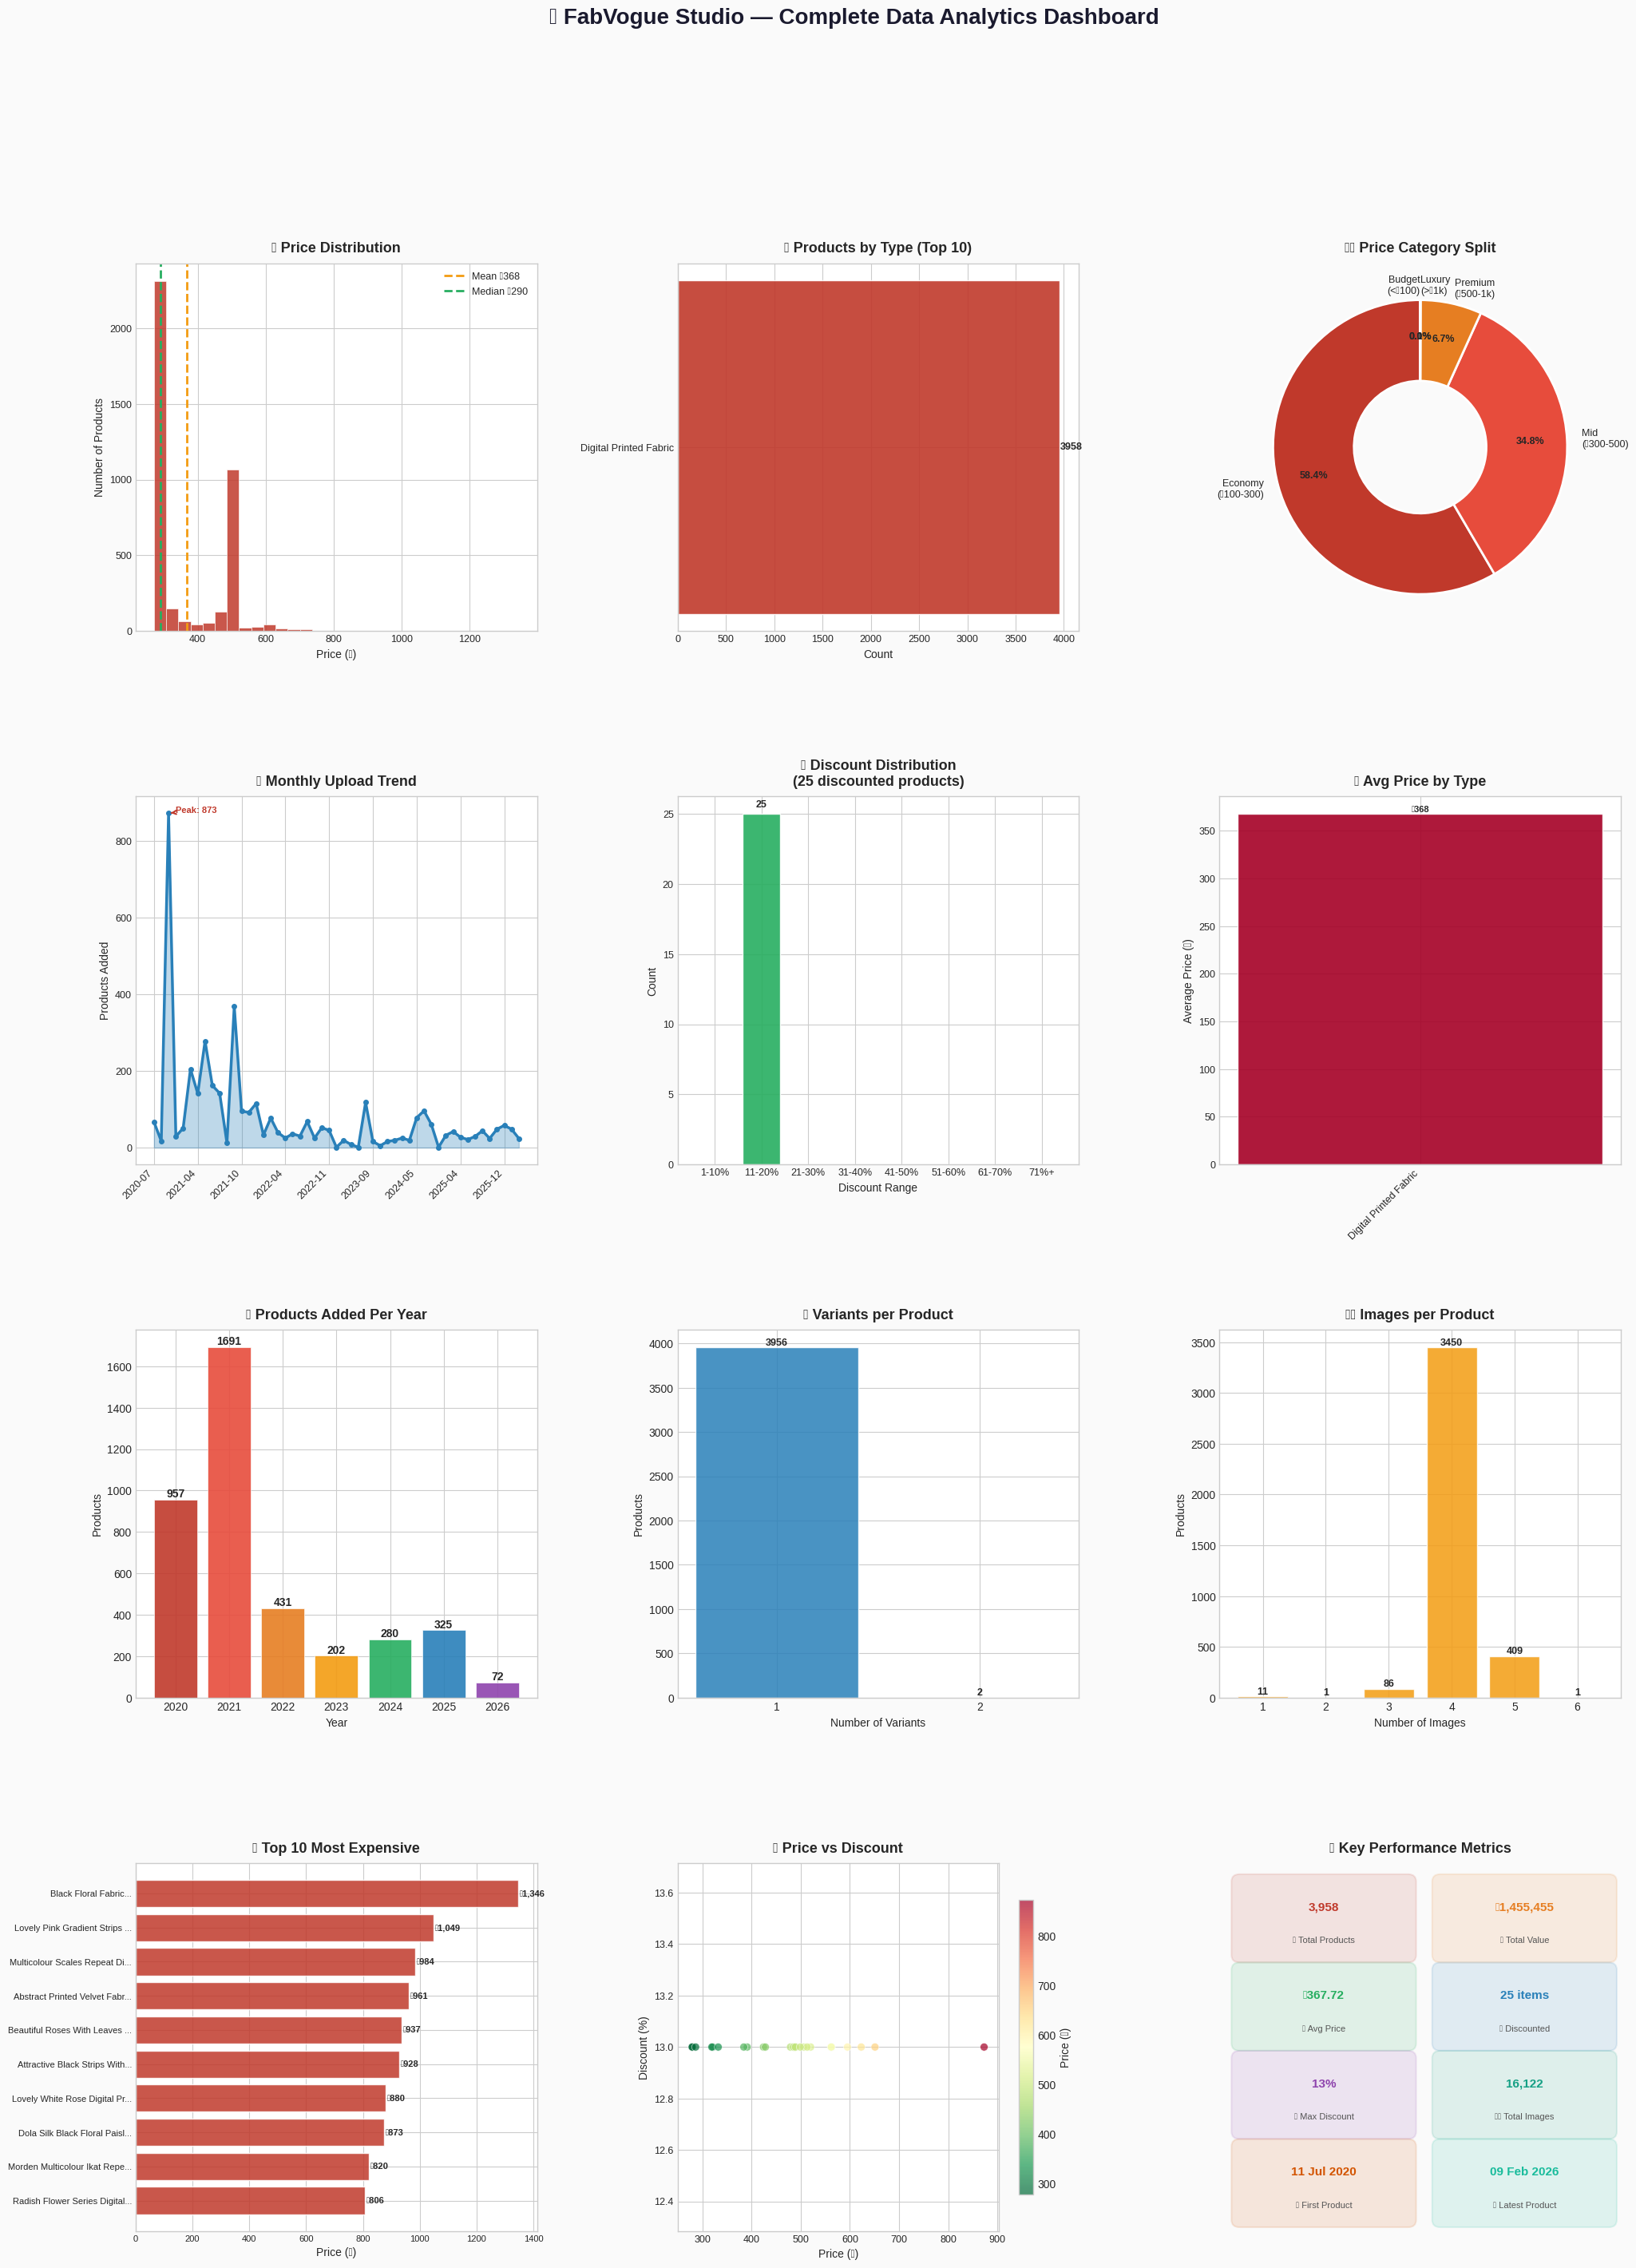

✅ Dashboard saved: fabvogue_analytics_dashboard.png

         🧠 KEY BUSINESS INSIGHTS

📌 INSIGHT 1 — Price Segmentation:
   Economy (₹100-300)        : 2313 products (58.4%)
   Mid (₹300-500)            : 1377 products (34.8%)
   Premium (₹500-1k)         :  266 products (6.7%)
   Luxury (>₹1k)             :    2 products (0.1%)
   Budget (<₹100)            :    0 products (0.0%)

📌 INSIGHT 2 — Top 5 Product Types:
   Digital Printed Fabric         : 3958 products | Avg ₹368

📌 INSIGHT 3 — Discount Strategy:
   Products WITH discount  : 25 | Avg Price ₹471 | Avg Discount 13.0%
   Products WITHOUT discount: 3933 | Avg Price ₹367

📌 INSIGHT 4 — Yearly Growth:
   2020 : ████████████████ 957
   2021 : ██████████████████████████████ 1691
   2022 : ███████ 431
   2023 : ███ 202
   2024 : ████ 280
   2025 : █████ 325
   2026 : █ 72

📌 INSIGHT 5 — Product Listing Quality:
   Avg images per product  : 4.1
   Products with 3+ images : 3946 (99.7%)
   Products with 2+ variants: 2 (0.1%)
   High q

In [15]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

# ============================================================
# STEP 1: DATA FETCH
# ============================================================
print("⏳ Data fetch ho raha hai...")
all_products = []
page = 1

while True:
    url = f"https://www.fabvoguestudio.com/collections/digital-printed-fabrics/products.json?limit=250&page={page}"
    response = requests.get(url)
    data = response.json()
    products = data.get("products", [])
    if not products:
        break
    for p in products:
        price   = float(p["variants"][0]["price"]) if p["variants"] else 0
        compare = float(p["variants"][0].get("compare_at_price") or 0) if p["variants"] else 0
        discount = round(((compare - price) / compare) * 100) if compare > price else 0
        created  = pd.to_datetime(p.get("created_at","")).tz_localize(None) if p.get("created_at") else pd.NaT
        updated  = pd.to_datetime(p.get("updated_at","")).tz_localize(None) if p.get("updated_at") else pd.NaT

        all_products.append({
            "id":           p["id"],
            "title":        p["title"],
            "vendor":       p.get("vendor",""),
            "type":         p.get("product_type","Unknown"),
            "tags":         p.get("tags",[]),
            "price":        price,
            "compare":      compare,
            "discount":     discount,
            "num_variants": len(p.get("variants",[])),
            "num_images":   len(p.get("images",[])),
            "created_at":   created,
            "updated_at":   updated,
            "handle":       p.get("handle",""),
        })
    print(f"  Page {page}: {len(products)} products")
    page += 1

df = pd.DataFrame(all_products)
df["created_month"]  = df["created_at"].dt.to_period("M")
df["created_year"]   = df["created_at"].dt.year
df["created_weekday"]= df["created_at"].dt.day_name()
df["has_discount"]   = df["discount"] > 0
df["price_category"] = pd.cut(df["price"],
    bins=[0,100,300,500,1000,99999],
    labels=["Budget\n(<₹100)","Economy\n(₹100-300)","Mid\n(₹300-500)","Premium\n(₹500-1k)","Luxury\n(>₹1k)"])

print(f"\n✅ Total Products Loaded: {len(df)}")

# ============================================================
# STEP 2: QUICK SUMMARY STATS
# ============================================================
print("\n" + "="*55)
print("         📊 FABVOGUE STUDIO — DATA INSIGHTS")
print("="*55)
print(f"  Total Products        : {len(df):,}")
print(f"  Unique Product Types  : {df['type'].nunique()}")
print(f"  Price Range           : ₹{df['price'].min():,.0f} — ₹{df['price'].max():,.0f}")
print(f"  Average Price         : ₹{df['price'].mean():,.2f}")
print(f"  Median Price          : ₹{df['price'].median():,.2f}")
print(f"  Products with Discount: {df['has_discount'].sum()} ({df['has_discount'].mean()*100:.1f}%)")
print(f"  Avg Discount          : {df[df['has_discount']]['discount'].mean():.1f}%")
print(f"  Max Discount          : {df['discount'].max()}%")
print(f"  Avg Variants/Product  : {df['num_variants'].mean():.1f}")
print(f"  Avg Images/Product    : {df['num_images'].mean():.1f}")
date_range = f"{df['created_at'].min().strftime('%d %b %Y')} → {df['created_at'].max().strftime('%d %b %Y')}"
print(f"  Catalog Date Range    : {date_range}")
print("="*55)

# ============================================================
# STEP 3: BIG DASHBOARD — 12 CHARTS
# ============================================================
plt.style.use('seaborn-v0_8-whitegrid')
COLORS = ['#c0392b','#e74c3c','#e67e22','#f39c12','#27ae60',
          '#2980b9','#8e44ad','#16a085','#d35400','#2c3e50']
RED    = '#c0392b'
GOLD   = '#f39c12'
GREEN  = '#27ae60'
BLUE   = '#2980b9'

fig = plt.figure(figsize=(24, 32))
fig.patch.set_facecolor('#fafafa')
gs  = gridspec.GridSpec(4, 3, figure=fig, hspace=0.45, wspace=0.35)

fig.suptitle("🧵 FabVogue Studio — Complete Data Analytics Dashboard",
             fontsize=20, fontweight='bold', y=0.98, color='#1a1a2e')

# ────────────────────────────────────────────────
# CHART 1: Price Distribution (Histogram)
# ────────────────────────────────────────────────
ax1 = fig.add_subplot(gs[0, 0])
prices_clean = df[df['price'] > 0]['price']
ax1.hist(prices_clean, bins=30, color=RED, alpha=0.85, edgecolor='white', linewidth=0.5)
ax1.axvline(prices_clean.mean(),   color=GOLD,  linestyle='--', linewidth=2, label=f'Mean ₹{prices_clean.mean():.0f}')
ax1.axvline(prices_clean.median(), color=GREEN, linestyle='--', linewidth=2, label=f'Median ₹{prices_clean.median():.0f}')
ax1.set_title('💰 Price Distribution', fontsize=13, fontweight='bold', pad=10)
ax1.set_xlabel('Price (₹)', fontsize=10)
ax1.set_ylabel('Number of Products', fontsize=10)
ax1.legend(fontsize=9)
ax1.tick_params(labelsize=9)

# ────────────────────────────────────────────────
# CHART 2: Products by Type (Horizontal Bar)
# ────────────────────────────────────────────────
ax2 = fig.add_subplot(gs[0, 1])
type_counts = df['type'].value_counts().head(10)
bars = ax2.barh(type_counts.index, type_counts.values,
                color=COLORS[:len(type_counts)], alpha=0.9, edgecolor='white')
for bar, val in zip(bars, type_counts.values):
    ax2.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
             str(val), va='center', fontsize=9, fontweight='600')
ax2.set_title('📦 Products by Type (Top 10)', fontsize=13, fontweight='bold', pad=10)
ax2.set_xlabel('Count', fontsize=10)
ax2.tick_params(labelsize=9)
ax2.invert_yaxis()

# ────────────────────────────────────────────────
# CHART 3: Price Category Donut
# ────────────────────────────────────────────────
ax3 = fig.add_subplot(gs[0, 2])
pcat = df['price_category'].value_counts()
wedges, texts, autotexts = ax3.pie(
    pcat.values,
    labels=pcat.index,
    autopct='%1.1f%%',
    colors=COLORS[:len(pcat)],
    startangle=90,
    wedgeprops=dict(width=0.55, edgecolor='white', linewidth=2),
    pctdistance=0.75,
    textprops={'fontsize':9}
)
for at in autotexts:
    at.set_fontweight('bold')
ax3.set_title('🏷️ Price Category Split', fontsize=13, fontweight='bold', pad=10)

# ────────────────────────────────────────────────
# CHART 4: Monthly Product Upload Trend
# ────────────────────────────────────────────────
ax4 = fig.add_subplot(gs[1, 0])
monthly = df.groupby('created_month').size()
months_str = [str(m) for m in monthly.index]
ax4.fill_between(range(len(months_str)), monthly.values,
                 alpha=0.3, color=BLUE)
ax4.plot(range(len(months_str)), monthly.values,
         color=BLUE, linewidth=2.5, marker='o', markersize=4)
peak_idx = monthly.values.argmax()
ax4.annotate(f'Peak: {monthly.values[peak_idx]}',
             xy=(peak_idx, monthly.values[peak_idx]),
             xytext=(peak_idx+1, monthly.values[peak_idx]+2),
             fontsize=8, color=RED, fontweight='bold',
             arrowprops=dict(arrowstyle='->', color=RED, lw=1.5))
step = max(1, len(months_str)//8)
ax4.set_xticks(range(0, len(months_str), step))
ax4.set_xticklabels([months_str[i] for i in range(0, len(months_str), step)],
                    rotation=45, ha='right', fontsize=8)
ax4.set_title('📅 Monthly Upload Trend', fontsize=13, fontweight='bold', pad=10)
ax4.set_ylabel('Products Added', fontsize=10)
ax4.tick_params(labelsize=9)

# ────────────────────────────────────────────────
# CHART 5: Discount Distribution
# ────────────────────────────────────────────────
ax5 = fig.add_subplot(gs[1, 1])
disc_df = df[df['discount'] > 0]['discount']
if len(disc_df) > 0:
    disc_bins = [0,10,20,30,40,50,60,70,100]
    disc_labels = ['1-10%','11-20%','21-30%','31-40%','41-50%','51-60%','61-70%','71%+']
    disc_counts = pd.cut(disc_df, bins=disc_bins, labels=disc_labels).value_counts().sort_index()
    bars5 = ax5.bar(disc_counts.index, disc_counts.values,
                    color=[GREEN if i < 3 else GOLD if i < 5 else RED
                           for i in range(len(disc_counts))],
                    alpha=0.9, edgecolor='white')
    for bar, val in zip(bars5, disc_counts.values):
        if val > 0:
            ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                     str(val), ha='center', va='bottom', fontsize=9, fontweight='600')
    ax5.set_title(f'🎯 Discount Distribution\n({len(disc_df)} discounted products)',
                  fontsize=13, fontweight='bold', pad=10)
    ax5.set_xlabel('Discount Range', fontsize=10)
    ax5.set_ylabel('Count', fontsize=10)
    ax5.tick_params(labelsize=9)
else:
    ax5.text(0.5, 0.5, 'No discounted\nproducts found',
             ha='center', va='center', transform=ax5.transAxes, fontsize=12)
    ax5.set_title('🎯 Discount Distribution', fontsize=13, fontweight='bold')

# ────────────────────────────────────────────────
# CHART 6: Avg Price by Product Type
# ────────────────────────────────────────────────
ax6 = fig.add_subplot(gs[1, 2])
avg_price_type = df.groupby('type')['price'].mean().sort_values(ascending=False).head(10)
bars6 = ax6.bar(range(len(avg_price_type)), avg_price_type.values,
                color=[plt.cm.RdYlGn(i/len(avg_price_type)) for i in range(len(avg_price_type))],
                alpha=0.9, edgecolor='white')
for bar, val in zip(bars6, avg_price_type.values):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'₹{val:.0f}', ha='center', va='bottom', fontsize=8, fontweight='600')
ax6.set_xticks(range(len(avg_price_type)))
ax6.set_xticklabels(avg_price_type.index, rotation=45, ha='right', fontsize=8)
ax6.set_title('💹 Avg Price by Type', fontsize=13, fontweight='bold', pad=10)
ax6.set_ylabel('Average Price (₹)', fontsize=10)
ax6.tick_params(labelsize=9)

# ────────────────────────────────────────────────
# CHART 7: Yearly Upload Bar
# ────────────────────────────────────────────────
ax7 = fig.add_subplot(gs[2, 0])
yearly = df.groupby('created_year').size().dropna()
yearly = yearly[yearly.index > 2000]
bar7 = ax7.bar(yearly.index.astype(str), yearly.values,
               color=COLORS[:len(yearly)], alpha=0.9, edgecolor='white', linewidth=0.5)
for bar, val in zip(bar7, yearly.values):
    ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='700')
ax7.set_title('📆 Products Added Per Year', fontsize=13, fontweight='bold', pad=10)
ax7.set_xlabel('Year', fontsize=10)
ax7.set_ylabel('Products', fontsize=10)
ax7.tick_params(labelsize=10)

# ────────────────────────────────────────────────
# CHART 8: Variants Distribution
# ────────────────────────────────────────────────
ax8 = fig.add_subplot(gs[2, 1])
var_counts = df['num_variants'].value_counts().sort_index().head(10)
ax8.bar(var_counts.index.astype(str), var_counts.values,
        color=BLUE, alpha=0.85, edgecolor='white')
for i, (idx, val) in enumerate(zip(var_counts.index, var_counts.values)):
    ax8.text(i, val + 0.3, str(val), ha='center', va='bottom', fontsize=9, fontweight='600')
ax8.set_title('🔢 Variants per Product', fontsize=13, fontweight='bold', pad=10)
ax8.set_xlabel('Number of Variants', fontsize=10)
ax8.set_ylabel('Products', fontsize=10)
ax8.tick_params(labelsize=10)

# ────────────────────────────────────────────────
# CHART 9: Images per Product
# ────────────────────────────────────────────────
ax9 = fig.add_subplot(gs[2, 2])
img_counts = df['num_images'].value_counts().sort_index().head(10)
ax9.bar(img_counts.index.astype(str), img_counts.values,
        color=GOLD, alpha=0.85, edgecolor='white')
for i, (idx, val) in enumerate(zip(img_counts.index, img_counts.values)):
    ax9.text(i, val + 0.3, str(val), ha='center', va='bottom', fontsize=9, fontweight='600')
ax9.set_title('🖼️ Images per Product', fontsize=13, fontweight='bold', pad=10)
ax9.set_xlabel('Number of Images', fontsize=10)
ax9.set_ylabel('Products', fontsize=10)
ax9.tick_params(labelsize=10)

# ────────────────────────────────────────────────
# CHART 10: Top 10 Most Expensive Products
# ────────────────────────────────────────────────
ax10 = fig.add_subplot(gs[3, 0])
top10 = df.nlargest(10, 'price')[['title','price']].reset_index(drop=True)
top10['short'] = top10['title'].str[:28] + '...'
bars10 = ax10.barh(top10['short'], top10['price'],
                   color=[RED]*len(top10), alpha=0.85, edgecolor='white')
for bar, val in zip(bars10, top10['price']):
    ax10.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
              f'₹{val:,.0f}', va='center', fontsize=8, fontweight='600')
ax10.set_title('🔝 Top 10 Most Expensive', fontsize=13, fontweight='bold', pad=10)
ax10.set_xlabel('Price (₹)', fontsize=10)
ax10.tick_params(labelsize=8)
ax10.invert_yaxis()

# ────────────────────────────────────────────────
# CHART 11: Price vs Discount Scatter
# ────────────────────────────────────────────────
ax11 = fig.add_subplot(gs[3, 1])
disc_products = df[df['discount'] > 0]
if len(disc_products) > 0:
    scatter = ax11.scatter(
        disc_products['price'],
        disc_products['discount'],
        c=disc_products['price'],
        cmap='RdYlGn_r',
        alpha=0.7, s=50, edgecolors='white', linewidth=0.5
    )
    plt.colorbar(scatter, ax=ax11, label='Price (₹)', shrink=0.8)
    ax11.set_title('💡 Price vs Discount', fontsize=13, fontweight='bold', pad=10)
    ax11.set_xlabel('Price (₹)', fontsize=10)
    ax11.set_ylabel('Discount (%)', fontsize=10)
    ax11.tick_params(labelsize=9)
else:
    ax11.text(0.5, 0.5, 'No discount data', ha='center', va='center',
              transform=ax11.transAxes, fontsize=12)
    ax11.set_title('💡 Price vs Discount', fontsize=13, fontweight='bold')

# ────────────────────────────────────────────────
# CHART 12: KPI Summary Card
# ────────────────────────────────────────────────
ax12 = fig.add_subplot(gs[3, 2])
ax12.axis('off')

kpis = [
    ("📦 Total Products",    f"{len(df):,}",                     '#c0392b'),
    ("💰 Total Value",       f"₹{df['price'].sum():,.0f}",       '#e67e22'),
    ("📊 Avg Price",         f"₹{df['price'].mean():,.2f}",      '#27ae60'),
    ("🎯 Discounted",        f"{df['has_discount'].sum()} items", '#2980b9'),
    ("🔥 Max Discount",      f"{df['discount'].max()}%",          '#8e44ad'),
    ("🖼️ Total Images",      f"{df['num_images'].sum():,}",       '#16a085'),
    ("📅 First Product",     df['created_at'].min().strftime('%d %b %Y'), '#d35400'),
    ("🆕 Latest Product",    df['created_at'].max().strftime('%d %b %Y'), '#1abc9c'),
]

ax12.set_xlim(0, 1); ax12.set_ylim(0, 1)
for i, (label, value, color) in enumerate(kpis):
    row = i // 2
    col = i % 2
    x = 0.05 + col * 0.5
    y = 0.92 - row * 0.24
    ax12.add_patch(mpatches.FancyBboxPatch(
        (x, y-0.17), 0.42, 0.20,
        boxstyle="round,pad=0.02",
        facecolor=color, alpha=0.12,
        edgecolor=color, linewidth=1.5,
        transform=ax12.transAxes
    ))
    ax12.text(x+0.21, y-0.04, value, ha='center', va='center',
              fontsize=11, fontweight='800', color=color,
              transform=ax12.transAxes)
    ax12.text(x+0.21, y-0.13, label, ha='center', va='center',
              fontsize=8, color='#555',
              transform=ax12.transAxes)

ax12.set_title('📋 Key Performance Metrics', fontsize=13, fontweight='bold', pad=10)

plt.savefig("fabvogue_analytics_dashboard.png", dpi=150,
            bbox_inches='tight', facecolor='#fafafa')
plt.show()
print("✅ Dashboard saved: fabvogue_analytics_dashboard.png")

# ============================================================
# STEP 4: BUSINESS INSIGHTS PRINT
# ============================================================
print("\n" + "="*60)
print("         🧠 KEY BUSINESS INSIGHTS")
print("="*60)

# Insight 1: Price Segments
print("\n📌 INSIGHT 1 — Price Segmentation:")
for cat, cnt in df['price_category'].value_counts().items():
    pct = cnt/len(df)*100
    print(f"   {cat.replace(chr(10),' '):<25} : {cnt:>4} products ({pct:.1f}%)")

# Insight 2: Best selling type estimate
print("\n📌 INSIGHT 2 — Top 5 Product Types:")
for t, cnt in df['type'].value_counts().head(5).items():
    avg = df[df['type']==t]['price'].mean()
    print(f"   {t:<30} : {cnt:>4} products | Avg ₹{avg:.0f}")

# Insight 3: Discount analysis
print("\n📌 INSIGHT 3 — Discount Strategy:")
disc = df[df['has_discount']]
no_disc = df[~df['has_discount']]
print(f"   Products WITH discount  : {len(disc)} | Avg Price ₹{disc['price'].mean():.0f} | Avg Discount {disc['discount'].mean():.1f}%")
print(f"   Products WITHOUT discount: {len(no_disc)} | Avg Price ₹{no_disc['price'].mean():.0f}")

# Insight 4: Growth trend
print("\n📌 INSIGHT 4 — Yearly Growth:")
for year, cnt in df.groupby('created_year').size().items():
    if year > 2000:
        bar_len = int(cnt / df.groupby('created_year').size().max() * 30)
        print(f"   {int(year)} : {'█'*bar_len} {cnt}")

# Insight 5: Product quality score
print("\n📌 INSIGHT 5 — Product Listing Quality:")
good = df[(df['num_images'] >= 3) & (df['num_variants'] >= 2)]
avg_img = df['num_images'].mean()
print(f"   Avg images per product  : {avg_img:.1f}")
print(f"   Products with 3+ images : {(df['num_images']>=3).sum()} ({(df['num_images']>=3).mean()*100:.1f}%)")
print(f"   Products with 2+ variants: {(df['num_variants']>=2).sum()} ({(df['num_variants']>=2).mean()*100:.1f}%)")
print(f"   High quality listings   : {len(good)} ({len(good)/len(df)*100:.1f}%)")

# Insight 6: Revenue opportunity
print("\n📌 INSIGHT 6 — Revenue Opportunity:")
total_catalog_value = df['price'].sum()
max_revenue = df['compare'].sum() if df['compare'].sum() > 0 else total_catalog_value
print(f"   Total catalog value     : ₹{total_catalog_value:,.0f}")
print(f"   Most expensive product  : ₹{df['price'].max():,.0f}")
print(f"   Cheapest product        : ₹{df['price'].min():,.0f}")
print(f"   Sweet spot (mode price) : ₹{df['price'].mode()[0]:,.0f}")

# Insight 7: Upload frequency
print("\n📌 INSIGHT 7 — Upload Frequency:")
date_diff = (df['created_at'].max() - df['created_at'].min()).days
if date_diff > 0:
    freq = len(df) / date_diff
    print(f"   Catalog span            : {date_diff} days")
    print(f"   Upload frequency        : {freq:.2f} products/day")
    print(f"   Estimated monthly adds  : {freq*30:.0f} products/month")

print("\n" + "="*60)
print("  ✅ Analysis Complete! Dashboard PNG bhi save ho gaya!")
print("="*60)

In [16]:
import json
import pandas as pd

# Load the JSON file that contains full product data, including descriptions
with open('fabvogue_products.json', 'r', encoding='utf-8') as f:
    all_products_with_desc = json.load(f)

# Create a DataFrame from this data
df_full = pd.DataFrame(all_products_with_desc)

# Display the first few rows and the columns to verify 'description'
print(df_full.head())
print("\nAvailable columns:", df_full.columns.tolist())

              id                                              title  \
0  6150548979905  Beautiful Floral Vine Over Brown Base Digital ...   
1  6139780366529  Red And White Flower Digital Printed Fabric - ...   
2  6635996250305  Glorry Beautiful Flower Digital Printed Fabric...   
3  8002440593632  Tusser Silk Digital Printed Fabric in Beautifu...   
4  6150568673473  Paisley Seamless over Black Digital Printed Fa...   

             vendor            product_type  \
0  FAB VOGUE Studio  Digital Printed Fabric   
1  FAB VOGUE Studio  Digital Printed Fabric   
2  FAB VOGUE Studio  Digital Printed Fabric   
3  FAB VOGUE Studio  Digital Printed Fabric   
4  FAB VOGUE Studio  Digital Printed Fabric   

                                                tags   price compare_price  \
0  [brown, floral, FVs, NIS, polyester, tusser silk]  279.00        279.00   
1     [floral, FVs, NIS, polyester, red, weightless]  288.00        288.00   
2  [blue, floral, FVs, gradient, NIS, polyester, ...  28

Now that we have the full product data including the `description` column, let's search for keywords related to 'return policy'.

In [17]:
# Define keywords to search for (case-insensitive)
keywords = ['return policy', 'refund policy', 'returns', 'exchange', 'warranty']

# Create a regex pattern from the keywords
pattern = '|'.join(keywords)

# Filter products where the description contains any of the keywords
# Ensure 'description' column is treated as string and handle potential NaNs
return_policy_products = df_full[df_full['description'].astype(str).str.contains(pattern, case=False, na=False)]

print(f"Found {len(return_policy_products)} products mentioning a return policy or related terms.")

if not return_policy_products.empty:
    print("\nProducts with return policy mentions (first 5):")
    display(return_policy_products[['title', 'url', 'description']].head()) # Display relevant columns
else:
    print("No products found with explicit mentions of a return policy or related terms in their descriptions.")

Found 0 products mentioning a return policy or related terms.
No products found with explicit mentions of a return policy or related terms in their descriptions.


✅ Libraries ready!

⏳ Data fetch ho raha hai...
  Page 1: 250 products
  Page 2: 250 products
  Page 3: 250 products
  Page 4: 250 products
  Page 5: 250 products
  Page 6: 250 products
  Page 7: 250 products
  Page 8: 250 products
  Page 9: 250 products
  Page 10: 250 products
  Page 11: 250 products
  Page 12: 250 products
  Page 13: 250 products
  Page 14: 250 products
  Page 15: 250 products
  Page 16: 220 products

✅ Total Products: 3970
   Features engineered: 29 columns

🔵 MODULE 1: KMeans Clustering...
   Optimal K = 2 (Silhouette Score: 0.890)

   Cluster Profiles:
   Cluster 0 [⭐ Mid-Range (3945)]: 3945 products | Avg ₹367 | Avg Discount 0.0%
   Cluster 1 [⭐ Mid-Range (25)]: 25 products | Avg ₹471 | Avg Discount 13.0%

🔴 MODULE 2: Anomaly Detection (Isolation Forest)...
   Anomalies detected: 199 products
   Anomaly products (sample):
   → Glorry Beautiful Flower Digital Printed Fabri... | ₹288.0 | Discount:0%
   → Beautifull Pink Calendula Flower Digital Prin... | ₹489.0 | D

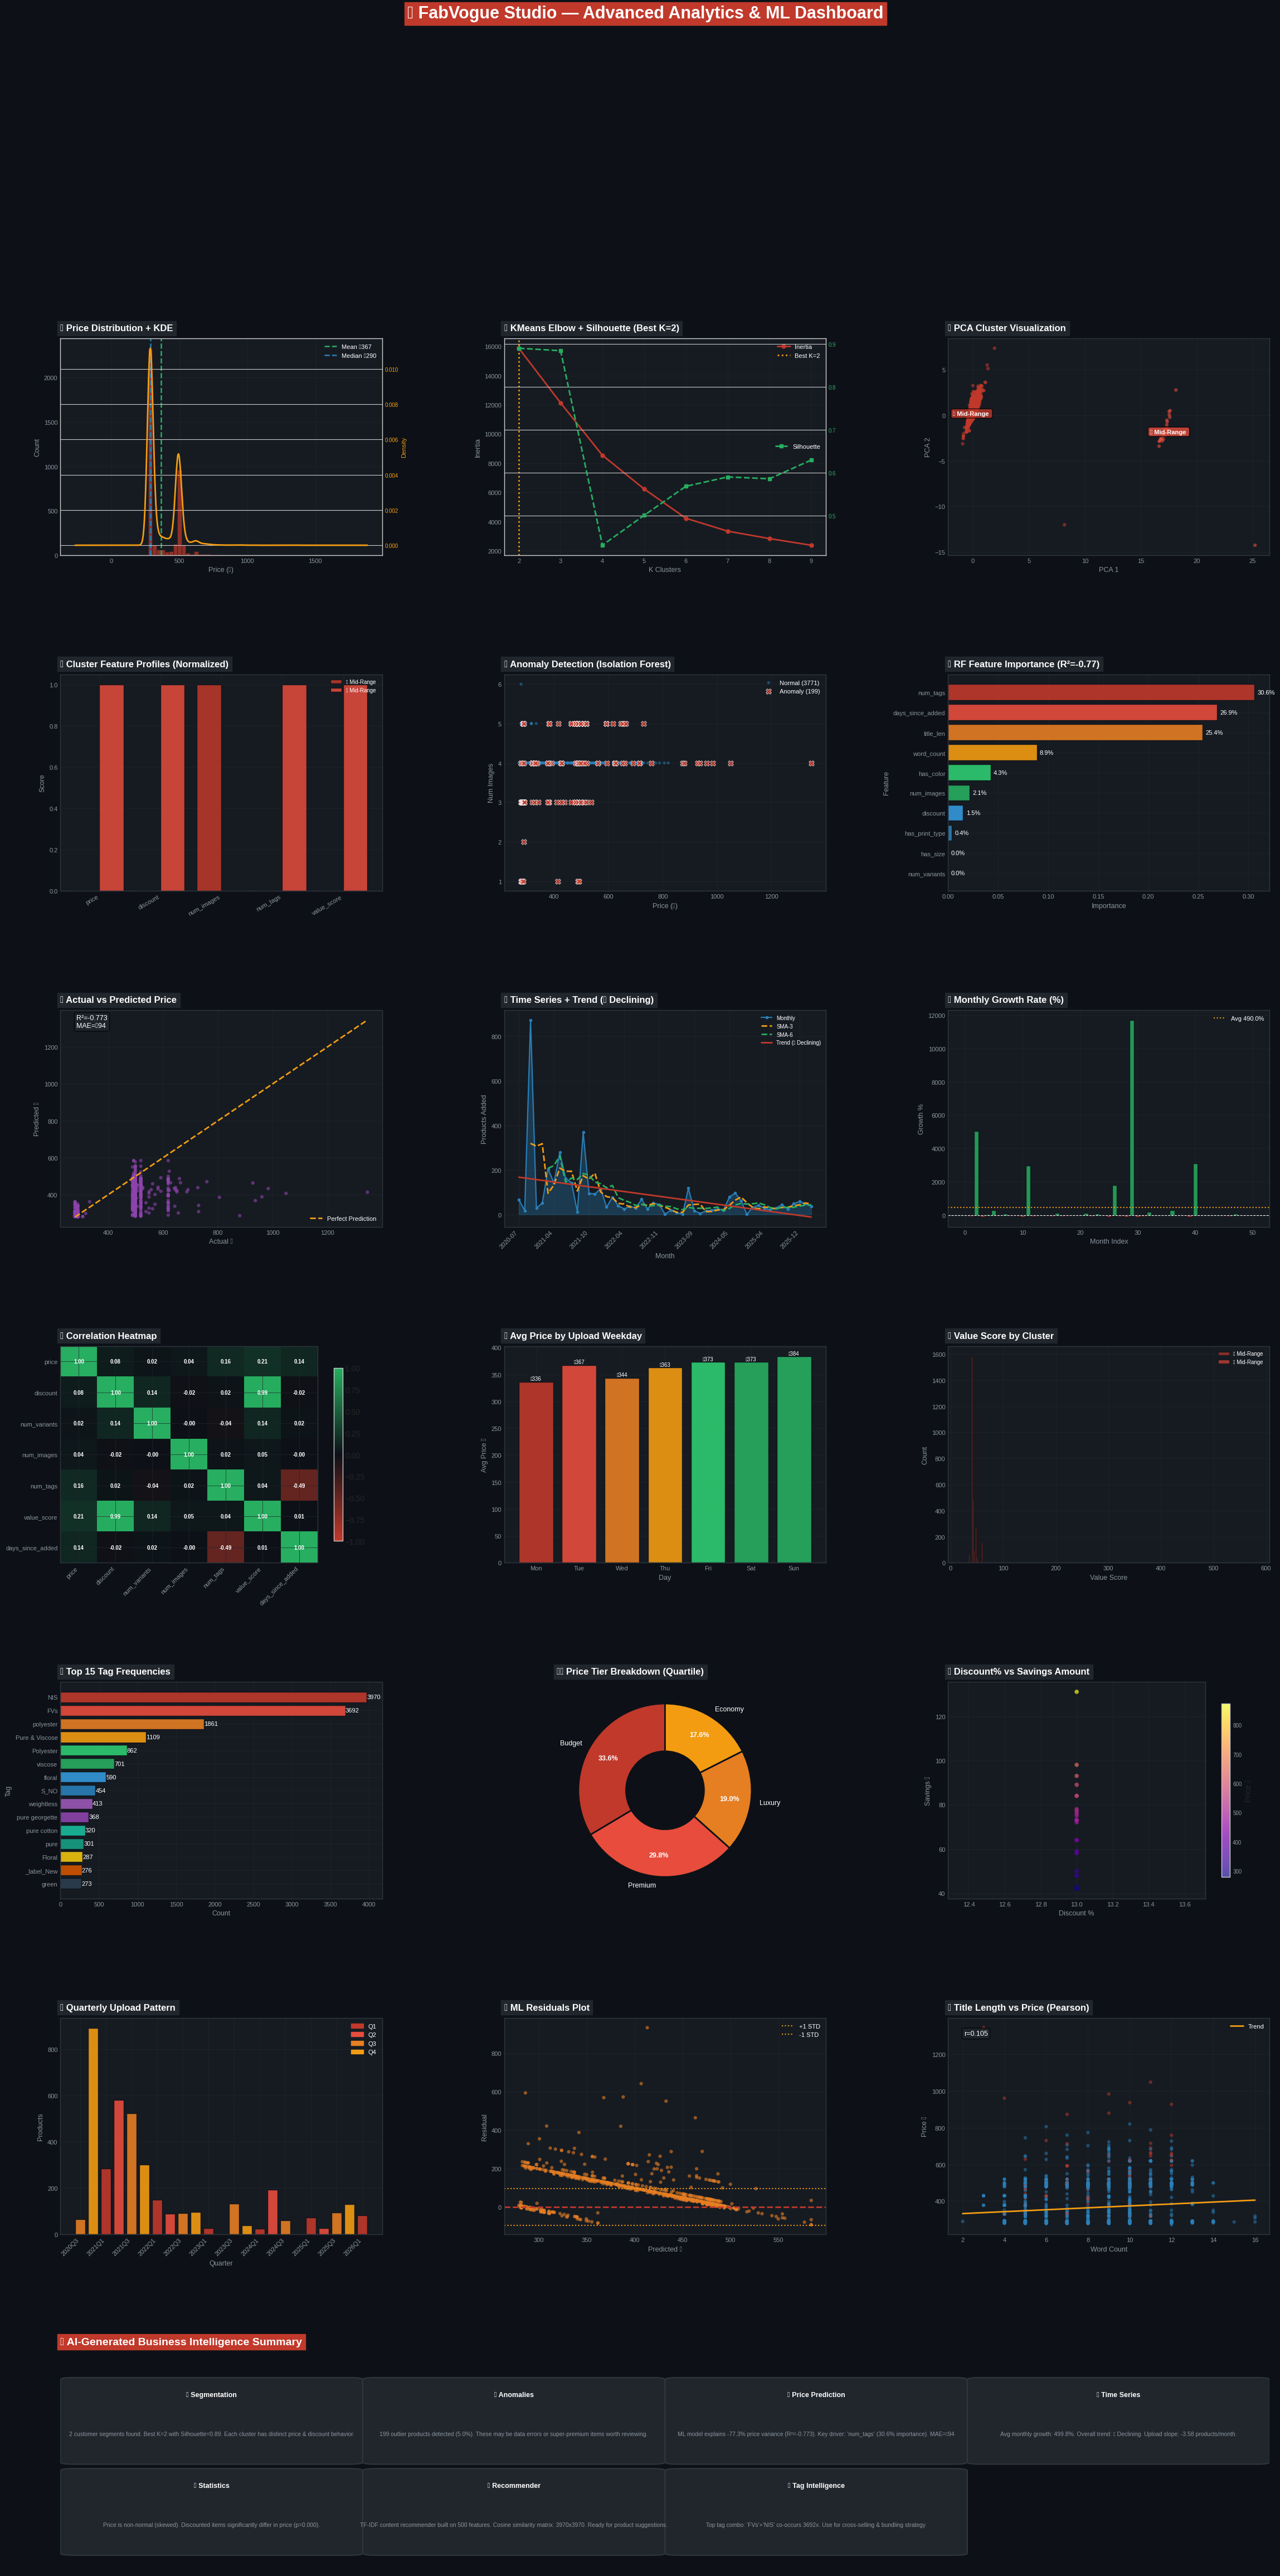

✅ Advanced dashboard saved: fabvogue_advanced_dashboard.png

██████████████████████████████████████████████████████████████
  🧠 FABVOGUE STUDIO — ADVANCED ANALYTICS FINAL REPORT
██████████████████████████████████████████████████████████████

📦 DATASET
   Total Products     : 3,970
   Date Range         : 11 Jul 2020 → 16 Feb 2026
   Features Used      : 37

🔵 CLUSTERING (KMeans)
   Optimal Clusters   : 2
   Silhouette Score   : 0.890
   Cluster Sizes      : {0: 3945, 1: 25}

🔴 ANOMALY DETECTION (Isolation Forest)
   Anomalies Found    : 199 (5.0%)
   Normal Products    : 3771

🟢 PRICE PREDICTION (Random Forest)
   R² Score           : -0.773
   MAE                : ₹93.76
   Top Feature        : num_tags (30.6%)

🟡 TIME SERIES
   Monthly Growth     : 499.8% avg
   Trend              : 📉 Declining
   Peak Month         : 2020-12

🟣 RECOMMENDER SYSTEM
   Algorithm          : TF-IDF + Cosine Similarity
   Vocabulary Size    : 500
   Matrix Size        : 3970×3970

⚪ STATISTICS
   Price Di

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import warnings
from datetime import datetime
from collections import Counter
import re

warnings.filterwarnings('ignore')

# ============================================================
# INSTALL REQUIRED LIBRARIES
# ============================================================
import subprocess, sys
libs = ['scikit-learn','scipy','wordcloud','networkx','seaborn']
for lib in libs:
    subprocess.run([sys.executable,'-m','pip','install',lib,'-q'])

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
from scipy.stats import pearsonr
import seaborn as sns
try:
    from wordcloud import WordCloud
    WORDCLOUD_OK = True
except:
    WORDCLOUD_OK = False
try:
    import networkx as nx
    NX_OK = True
except:
    NX_OK = False

print("✅ Libraries ready!")

# ============================================================
# STEP 1: DATA FETCH + FEATURE ENGINEERING
# ============================================================
print("\n⏳ Data fetch ho raha hai...")
all_products = []
page = 1

while True:
    url = f"https://www.fabvoguestudio.com/collections/digital-printed-fabrics/products.json?limit=250&page={page}"
    response = requests.get(url)
    data = response.json()
    products = data.get("products", [])
    if not products:
        break
    for p in products:
        price   = float(p["variants"][0]["price"]) if p["variants"] else 0
        compare = float(p["variants"][0].get("compare_at_price") or 0) if p["variants"] else 0
        discount = round(((compare - price) / compare)*100) if compare > price else 0
        created  = pd.to_datetime(p.get("created_at","")).tz_localize(None) if p.get("created_at") else pd.NaT
        tags     = p.get("tags", [])
        title    = p.get("title","")
        desc     = re.sub('<.*?>','', p.get("body_html",""))

        # Feature engineering
        title_len      = len(title)
        word_count     = len(title.split())
        has_size       = any(s in title.lower() for s in ['meter','mtr','yard','width'])
        has_color      = any(c in title.lower() for c in ['red','blue','green','pink','yellow','black','white','orange','purple','grey','brown','multi'])
        has_print_type = any(pt in title.lower() for pt in ['floral','geometric','abstract','paisley','stripe','checks','plain','printed','digital'])
        num_tags       = len(tags)
        savings        = compare - price if compare > price else 0
        value_score    = (discount * 0.4 + min(price/500,1)*0.3 + min(len(p.get("images",[]))/5,1)*0.3) * 100

        all_products.append({
            "id":            p["id"],
            "title":         title,
            "desc":          desc,
            "vendor":        p.get("vendor",""),
            "type":          p.get("product_type","Unknown"),
            "tags":          tags,
            "tags_str":      " ".join(tags),
            "price":         price,
            "compare":       compare,
            "discount":      discount,
            "savings":       savings,
            "num_variants":  len(p.get("variants",[])),
            "num_images":    len(p.get("images",[])),
            "num_tags":      num_tags,
            "title_len":     title_len,
            "word_count":    word_count,
            "has_size":      int(has_size),
            "has_color":     int(has_color),
            "has_print_type":int(has_print_type),
            "value_score":   value_score,
            "created_at":    created,
        })
    print(f"  Page {page}: {len(products)} products")
    page += 1

df = pd.DataFrame(all_products)
df["created_month"]   = df["created_at"].dt.to_period("M")
df["created_year"]    = df["created_at"].dt.year.fillna(0).astype(int)
df["created_weekday"] = df["created_at"].dt.day_name()
df["created_quarter"] = df["created_at"].dt.quarter
df["days_since_added"]= (datetime.now() - df["created_at"]).dt.days
df["price_log"]       = np.log1p(df["price"])
df["has_discount"]    = df["discount"] > 0
df["price_tier"]      = pd.qcut(df["price"], q=4, labels=["Budget","Economy","Premium","Luxury"], duplicates='drop')

print(f"\n✅ Total Products: {len(df)}")
print(f"   Features engineered: {df.shape[1]} columns")

# ============================================================
# ██████████  MODULE 1: CLUSTERING ANALYSIS  ██████████
# ============================================================
print("\n🔵 MODULE 1: KMeans Clustering...")

features_cluster = ['price','discount','num_variants','num_images','num_tags','value_score']
df_cluster = df[features_cluster].fillna(0)
scaler     = StandardScaler()
X_scaled   = scaler.fit_transform(df_cluster)

# Elbow Method — optimal K
inertias    = []
sil_scores  = []
K_range     = range(2, 10)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, km.labels_))

best_k = K_range[np.argmax(sil_scores)]
print(f"   Optimal K = {best_k} (Silhouette Score: {max(sil_scores):.3f})")

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df["pca_x"] = X_pca[:, 0]
df["pca_y"] = X_pca[:, 1]

# Cluster profiles
print("\n   Cluster Profiles:")
cluster_names = {}
for c in range(best_k):
    sub = df[df["cluster"]==c]
    avg_p = sub["price"].mean()
    avg_d = sub["discount"].mean()
    if avg_p > df["price"].quantile(0.75):
        name = f"💎 Premium ({len(sub)})"
    elif avg_d > 20:
        name = f"🔥 Hot Deals ({len(sub)})"
    elif avg_p < df["price"].quantile(0.25):
        name = f"💚 Budget ({len(sub)})"
    else:
        name = f"⭐ Mid-Range ({len(sub)})"
    cluster_names[c] = name
    print(f"   Cluster {c} [{name}]: {len(sub)} products | Avg ₹{avg_p:.0f} | Avg Discount {avg_d:.1f}%")

df["cluster_name"] = df["cluster"].map(cluster_names)

# ============================================================
# ██████████  MODULE 2: ANOMALY DETECTION  ██████████
# ============================================================
print("\n🔴 MODULE 2: Anomaly Detection (Isolation Forest)...")

iso = IsolationForest(contamination=0.05, random_state=42)
df["anomaly"] = iso.fit_predict(X_scaled)
df["is_anomaly"] = df["anomaly"] == -1

anomalies = df[df["is_anomaly"]]
print(f"   Anomalies detected: {len(anomalies)} products")
print(f"   Anomaly products (sample):")
for _, row in anomalies.head(5).iterrows():
    print(f"   → {row['title'][:45]}... | ₹{row['price']} | Discount:{row['discount']}%")

# ============================================================
# ██████████  MODULE 3: PRICE PREDICTION ML  ██████████
# ============================================================
print("\n🟢 MODULE 3: Price Prediction (Random Forest)...")

features_ml = ['discount','num_variants','num_images','num_tags',
                'title_len','word_count','has_size','has_color',
                'has_print_type','days_since_added']
le = LabelEncoder()
df["type_enc"] = le.fit_transform(df["type"].fillna("Unknown"))
features_ml.append("type_enc")

df_ml  = df[features_ml + ['price']].dropna()
X_ml   = df_ml[features_ml]
y_ml   = df_ml['price']

# Train/test split manually
split  = int(len(X_ml) * 0.8)
X_tr, X_te = X_ml[:split], X_ml[split:]
y_tr, y_te = y_ml[:split], y_ml[split:]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_tr, y_tr)
y_pred = rf.predict(X_te)

from sklearn.metrics import r2_score, mean_absolute_error
r2  = r2_score(y_te, y_pred)
mae = mean_absolute_error(y_te, y_pred)
print(f"   R² Score  : {r2:.3f} ({r2*100:.1f}% variance explained)")
print(f"   MAE       : ₹{mae:.2f}")

# Feature importance
fi = pd.Series(rf.feature_importances_, index=features_ml).sort_values(ascending=False)
print(f"   Top feature: '{fi.index[0]}' ({fi.iloc[0]*100:.1f}% importance)")

# ============================================================
# ██████████  MODULE 4: CONTENT-BASED RECOMMENDATION  ██████████
# ============================================================
print("\n🟣 MODULE 4: Content-Based Recommendation System...")

df["content"] = df["title"] + " " + df["type"] + " " + df["tags_str"]
tfidf    = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_mat = tfidf.fit_transform(df["content"].fillna(""))
cos_sim   = cosine_similarity(tfidf_mat, tfidf_mat)

def recommend(product_title, n=5):
    matches = df[df['title'].str.contains(product_title, case=False, na=False)]
    if matches.empty:
        return []
    idx  = matches.index[0]
    scores = list(enumerate(cos_sim[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:n+1]
    recs   = []
    for i, score in scores:
        recs.append({
            "title":      df.iloc[i]["title"],
            "price":      df.iloc[i]["price"],
            "similarity": f"{score*100:.1f}%"
        })
    return recs

sample_title = df["title"].iloc[0][:20]
recs = recommend(sample_title)
print(f"   Sample recommendations for '{sample_title}...':")
for r in recs[:3]:
    print(f"   → {r['title'][:40]}... | ₹{r['price']} | Similarity: {r['similarity']}")

# ============================================================
# ██████████  MODULE 5: TIME SERIES ANALYSIS  ██████████
# ============================================================
print("\n🟡 MODULE 5: Time Series Trend Analysis...")

monthly_ts = df.groupby("created_month").agg(
    count  = ('id','count'),
    avg_price = ('price','mean'),
    total_discount = ('discount','sum')
).reset_index()
monthly_ts.index = range(len(monthly_ts))

# Simple moving average
monthly_ts["SMA_3"] = monthly_ts["count"].rolling(3).mean()
monthly_ts["SMA_6"] = monthly_ts["count"].rolling(6).mean()

# Growth rate
monthly_ts["growth_rate"] = monthly_ts["count"].pct_change() * 100
avg_growth = monthly_ts["growth_rate"].mean()
print(f"   Average monthly growth rate : {avg_growth:.1f}%")
print(f"   Best month: {monthly_ts.loc[monthly_ts['count'].idxmax(), 'created_month']} ({monthly_ts['count'].max()} products)")
print(f"   Worst month: {monthly_ts.loc[monthly_ts['count'].idxmin(), 'created_month']} ({monthly_ts['count'].min()} products)")

# Linear trend
X_ts = np.arange(len(monthly_ts)).reshape(-1,1)
lr   = LinearRegression().fit(X_ts, monthly_ts["count"])
slope = lr.coef_[0]
trend = "📈 Growing" if slope > 0 else "📉 Declining"
print(f"   Overall trend: {trend} (slope={slope:.2f} products/month)")

# ============================================================
# ██████████  MODULE 6: STATISTICAL TESTS  ██████████
# ============================================================
print("\n⚪ MODULE 6: Statistical Tests...")

# T-test: discounted vs non-discounted prices
disc_prices    = df[df["has_discount"]]["price"].dropna()
no_disc_prices = df[~df["has_discount"]]["price"].dropna()
t_stat, p_val  = stats.ttest_ind(disc_prices, no_disc_prices)
print(f"   T-test (Discount vs No-Discount prices):")
print(f"   t-statistic={t_stat:.3f}, p-value={p_val:.4f}")
print(f"   Result: {'✅ Significant difference' if p_val < 0.05 else '❌ No significant difference'}")

# Correlation matrix
corr_cols = ['price','discount','num_variants','num_images','num_tags','value_score']
corr_mat  = df[corr_cols].corr()
top_corr  = corr_mat["price"].drop("price").abs().sort_values(ascending=False)
print(f"\n   Top correlations with Price:")
for col, val in top_corr.head(3).items():
    print(f"   → {col}: {val:.3f}")

# Normality test on price
_, p_norm = stats.shapiro(df["price"].dropna().sample(min(500,len(df)), random_state=42))
print(f"\n   Normality test (Shapiro-Wilk): p={p_norm:.4f}")
print(f"   Price distribution: {'Normal' if p_norm > 0.05 else 'Not Normal (Skewed)'}")

# ============================================================
# ██████████  MODULE 7: MARKET BASKET / TAG ANALYSIS  ██████████
# ============================================================
print("\n🟠 MODULE 7: Tag Co-occurrence Analysis...")

tag_pairs = []
for tags in df["tags"]:
    if len(tags) >= 2:
        for i in range(len(tags)):
            for j in range(i+1, len(tags)):
                pair = tuple(sorted([tags[i], tags[j]]))
                tag_pairs.append(pair)

pair_counts = Counter(tag_pairs).most_common(10)
print("   Top Tag Pairs (Co-occurrence):")
for pair, cnt in pair_counts[:5]:
    print(f"   → '{pair[0]}' + '{pair[1]}' : {cnt} times")

# ============================================================
# ██████  NOW DRAW THE MEGA DASHBOARD (20 CHARTS)  ██████
# ============================================================
print("\n🎨 Drawing Mega Dashboard (20 charts)...")

plt.style.use('seaborn-v0_8-whitegrid')
COLORS = ['#c0392b','#e74c3c','#e67e22','#f39c12','#2ecc71',
          '#27ae60','#3498db','#2980b9','#9b59b6','#8e44ad',
          '#1abc9c','#16a085','#f1c40f','#d35400','#2c3e50']
RED=COLORS[0]; ORANGE=COLORS[2]; GOLD=COLORS[3]
GREEN=COLORS[5]; BLUE=COLORS[7]; PURPLE=COLORS[9]

fig = plt.figure(figsize=(28, 52))
fig.patch.set_facecolor('#0d1117')
gs  = gridspec.GridSpec(7, 3, figure=fig, hspace=0.55, wspace=0.38)

fig.suptitle("🧵 FabVogue Studio — Advanced Analytics & ML Dashboard",
             fontsize=22, fontweight='bold', y=0.995,
             color='white', backgroundcolor='#c0392b')

def style_ax(ax, title, xlabel="", ylabel=""):
    ax.set_facecolor('#161b22')
    ax.set_title(title, fontsize=12, fontweight='bold', pad=10,
                 color='white', backgroundcolor='#21262d', loc='left')
    if xlabel: ax.set_xlabel(xlabel, fontsize=9, color='#8b949e')
    if ylabel: ax.set_ylabel(ylabel, fontsize=9, color='#8b949e')
    ax.tick_params(colors='#8b949e', labelsize=8)
    for spine in ax.spines.values():
        spine.set_edgecolor('#30363d')
    ax.grid(color='#21262d', linewidth=0.5)

# ── ROW 0 ─────────────────────────────────────────────────

# C1: Price Distribution + KDE
ax = fig.add_subplot(gs[0, 0])
prices_clean = df[df['price']>0]['price']
ax.hist(prices_clean, bins=35, color=RED, alpha=0.7, edgecolor='#0d1117', linewidth=0.4)
ax2_ = ax.twinx()
prices_clean.plot.kde(ax=ax2_, color=GOLD, linewidth=2)
ax2_.set_ylabel("Density", color=GOLD, fontsize=8)
ax2_.tick_params(colors=GOLD, labelsize=7)
ax.axvline(prices_clean.mean(),   color=GREEN, linestyle='--', lw=1.8, label=f'Mean ₹{prices_clean.mean():.0f}')
ax.axvline(prices_clean.median(), color=BLUE,  linestyle='--', lw=1.8, label=f'Median ₹{prices_clean.median():.0f}')
ax.legend(fontsize=8, facecolor='#161b22', labelcolor='white')
style_ax(ax, "💰 Price Distribution + KDE", "Price (₹)", "Count")

# C2: Elbow + Silhouette
ax = fig.add_subplot(gs[0, 1])
ax2_ = ax.twinx()
ax.plot(list(K_range), inertias,    'o-', color=RED,   linewidth=2, markersize=5, label='Inertia')
ax2_.plot(list(K_range), sil_scores,'s--',color=GREEN, linewidth=2, markersize=5, label='Silhouette')
ax.axvline(best_k, color=GOLD, linestyle=':', linewidth=2, label=f'Best K={best_k}')
ax.set_xlabel("K", fontsize=9, color='#8b949e')
ax.legend(fontsize=8, facecolor='#161b22', labelcolor='white', loc='upper right')
ax2_.legend(fontsize=8, facecolor='#161b22', labelcolor='white', loc='center right')
ax2_.tick_params(colors=GREEN, labelsize=7)
style_ax(ax, f"🔵 KMeans Elbow + Silhouette (Best K={best_k})", "K Clusters", "Inertia")

# C3: PCA Cluster Scatter
ax = fig.add_subplot(gs[0, 2])
scatter_colors = [COLORS[c] for c in df["cluster"]]
ax.scatter(df["pca_x"], df["pca_y"], c=scatter_colors, alpha=0.6, s=20, edgecolors='none')
for c in range(best_k):
    sub = df[df["cluster"]==c]
    ax.annotate(cluster_names[c].split('(')[0],
                xy=(sub["pca_x"].mean(), sub["pca_y"].mean()),
                fontsize=8, color='white', fontweight='bold',
                ha='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=COLORS[c], alpha=0.8))
style_ax(ax, "🔵 PCA Cluster Visualization", "PCA 1", "PCA 2")

# ── ROW 1 ─────────────────────────────────────────────────

# C4: Cluster Profiles Radar / Bar
ax = fig.add_subplot(gs[1, 0])
cluster_stats = df.groupby("cluster")[["price","discount","num_images","num_tags","value_score"]].mean()
cluster_stats_norm = (cluster_stats - cluster_stats.min()) / (cluster_stats.max() - cluster_stats.min() + 1e-9)
x_ = np.arange(len(cluster_stats_norm.columns))
width = 0.8 / best_k
for i, (cidx, row) in enumerate(cluster_stats_norm.iterrows()):
    ax.bar(x_ + i*width, row.values, width, label=cluster_names[cidx].split('(')[0],
           color=COLORS[i], alpha=0.85, edgecolor='#0d1117')
ax.set_xticks(x_ + width*(best_k-1)/2)
ax.set_xticklabels(cluster_stats_norm.columns, rotation=30, ha='right', color='#8b949e', fontsize=8)
ax.legend(fontsize=7, facecolor='#161b22', labelcolor='white')
style_ax(ax, "🔵 Cluster Feature Profiles (Normalized)", "", "Score")

# C5: Anomaly Detection Scatter
ax = fig.add_subplot(gs[1, 1])
normal  = df[~df["is_anomaly"]]
anom    = df[df["is_anomaly"]]
ax.scatter(normal["price"], normal["num_images"], c=BLUE,  alpha=0.5, s=15, label=f'Normal ({len(normal)})',  edgecolors='none')
ax.scatter(anom["price"],   anom["num_images"],   c=RED,   alpha=0.9, s=50, label=f'Anomaly ({len(anom)})',  edgecolors='white', linewidth=0.5, marker='X')
ax.legend(fontsize=8, facecolor='#161b22', labelcolor='white')
style_ax(ax, "🔴 Anomaly Detection (Isolation Forest)", "Price (₹)", "Num Images")

# C6: Feature Importance (Random Forest)
ax = fig.add_subplot(gs[1, 2])
fi_sorted = fi.head(10)
bars = ax.barh(fi_sorted.index, fi_sorted.values,
               color=[COLORS[i] for i in range(len(fi_sorted))], alpha=0.9, edgecolor='#0d1117')
for bar, val in zip(bars, fi_sorted.values):
    ax.text(bar.get_width()+0.003, bar.get_y()+bar.get_height()/2,
            f'{val*100:.1f}%', va='center', fontsize=8, color='white')
ax.invert_yaxis()
style_ax(ax, f"🟢 RF Feature Importance (R²={r2:.2f})", "Importance", "Feature")

# ── ROW 2 ─────────────────────────────────────────────────

# C7: Actual vs Predicted Price
ax = fig.add_subplot(gs[2, 0])
ax.scatter(y_te, y_pred, c=PURPLE, alpha=0.6, s=20, edgecolors='none')
mn = min(y_te.min(), y_pred.min())
mx = max(y_te.max(), y_pred.max())
ax.plot([mn,mx],[mn,mx], color=GOLD, linewidth=2, linestyle='--', label='Perfect Prediction')
ax.legend(fontsize=8, facecolor='#161b22', labelcolor='white')
ax.text(0.05, 0.92, f'R²={r2:.3f}\nMAE=₹{mae:.0f}',
        transform=ax.transAxes, fontsize=9, color='white',
        bbox=dict(facecolor='#21262d', alpha=0.8, boxstyle='round'))
style_ax(ax, "🟢 Actual vs Predicted Price", "Actual ₹", "Predicted ₹")

# C8: Time Series + SMA
ax = fig.add_subplot(gs[2, 1])
x_ts = range(len(monthly_ts))
ax.fill_between(x_ts, monthly_ts["count"], alpha=0.3, color=BLUE)
ax.plot(x_ts, monthly_ts["count"], 'o-', color=BLUE,  linewidth=1.5, markersize=3,  label='Monthly')
ax.plot(x_ts, monthly_ts["SMA_3"], '--', color=GOLD,  linewidth=2,                  label='SMA-3')
ax.plot(x_ts, monthly_ts["SMA_6"], '--', color=GREEN, linewidth=2,                  label='SMA-6')
# Trend line
lr_y = lr.predict(np.arange(len(monthly_ts)).reshape(-1,1))
ax.plot(x_ts, lr_y, '-', color=RED, linewidth=2, label=f'Trend ({trend})')
ax.legend(fontsize=7, facecolor='#161b22', labelcolor='white')
step = max(1, len(monthly_ts)//8)
ax.set_xticks(range(0, len(monthly_ts), step))
ax.set_xticklabels([str(monthly_ts["created_month"].iloc[i]) for i in range(0, len(monthly_ts), step)],
                   rotation=45, ha='right', fontsize=7, color='#8b949e')
style_ax(ax, f"🟡 Time Series + Trend ({trend})", "Month", "Products Added")

# C9: Monthly Growth Rate
ax = fig.add_subplot(gs[2, 2])
growth = monthly_ts["growth_rate"].fillna(0)
colors_gr = [GREEN if v >= 0 else RED for v in growth]
ax.bar(range(len(growth)), growth, color=colors_gr, alpha=0.85, edgecolor='#0d1117')
ax.axhline(0, color='white', linewidth=0.8, linestyle='--')
ax.axhline(growth.mean(), color=GOLD, linewidth=1.5, linestyle=':', label=f'Avg {growth.mean():.1f}%')
ax.legend(fontsize=8, facecolor='#161b22', labelcolor='white')
style_ax(ax, "🟡 Monthly Growth Rate (%)", "Month Index", "Growth %")

# ── ROW 3 ─────────────────────────────────────────────────

# C10: Correlation Heatmap
ax = fig.add_subplot(gs[3, 0])
corr = df[['price','discount','num_variants','num_images','num_tags','value_score','days_since_added']].corr()
cmap = LinearSegmentedColormap.from_list("rg", ["#c0392b","#0d1117","#27ae60"])
im   = ax.imshow(corr.values, cmap=cmap, vmin=-1, vmax=1, aspect='auto')
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right', fontsize=7, color='#8b949e')
ax.set_yticklabels(corr.columns, fontsize=7, color='#8b949e')
for i in range(len(corr)):
    for j in range(len(corr)):
        ax.text(j, i, f'{corr.values[i,j]:.2f}', ha='center', va='center',
                fontsize=7, color='white', fontweight='bold')
plt.colorbar(im, ax=ax, shrink=0.8)
style_ax(ax, "⚪ Correlation Heatmap")

# C11: Price by Weekday Added (Box style bar)
ax = fig.add_subplot(gs[3, 1])
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_avg   = df.groupby("created_weekday")["price"].mean().reindex(weekday_order).fillna(0)
bars = ax.bar(range(len(weekday_avg)), weekday_avg.values,
              color=[GREEN if v == weekday_avg.max() else COLORS[i%len(COLORS)]
                     for i,v in enumerate(weekday_avg.values)],
              alpha=0.9, edgecolor='#0d1117')
ax.set_xticks(range(len(weekday_avg)))
ax.set_xticklabels([d[:3] for d in weekday_order], color='#8b949e', fontsize=9)
for bar, val in zip(bars, weekday_avg.values):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5,
            f'₹{val:.0f}', ha='center', va='bottom', fontsize=7, color='white')
style_ax(ax, "📅 Avg Price by Upload Weekday", "Day", "Avg Price ₹")

# C12: Value Score Distribution by Cluster
ax = fig.add_subplot(gs[3, 2])
for i, c in enumerate(range(best_k)):
    sub = df[df["cluster"]==c]["value_score"]
    ax.hist(sub, bins=20, alpha=0.65, color=COLORS[i],
            label=cluster_names[c].split('(')[0], edgecolor='#0d1117')
ax.legend(fontsize=7, facecolor='#161b22', labelcolor='white')
style_ax(ax, "🔵 Value Score by Cluster", "Value Score", "Count")

# ── ROW 4 ─────────────────────────────────────────────────

# C13: Tag Frequency
ax = fig.add_subplot(gs[4, 0])
all_tags = [tag for tags in df["tags"] for tag in tags]
tag_freq = Counter(all_tags).most_common(15)
tags_names  = [t[0][:20] for t in tag_freq]
tags_counts = [t[1] for t in tag_freq]
bars = ax.barh(tags_names, tags_counts,
               color=[COLORS[i%len(COLORS)] for i in range(len(tags_names))],
               alpha=0.9, edgecolor='#0d1117')
for bar, val in zip(bars, tags_counts):
    ax.text(bar.get_width()+0.3, bar.get_y()+bar.get_height()/2,
            str(val), va='center', fontsize=8, color='white')
ax.invert_yaxis()
style_ax(ax, "🟠 Top 15 Tag Frequencies", "Count", "Tag")

# C14: Price Tier Donut
ax = fig.add_subplot(gs[4, 1])
tier_cnt = df["price_tier"].value_counts()
wedges, texts, autotexts = ax.pie(
    tier_cnt.values, labels=tier_cnt.index,
    autopct='%1.1f%%',
    colors=COLORS[:len(tier_cnt)],
    startangle=90,
    wedgeprops=dict(width=0.55, edgecolor='#0d1117', linewidth=2),
    pctdistance=0.75,
    textprops={'fontsize':9,'color':'white'}
)
for at in autotexts: at.set_fontweight('bold')
ax.set_facecolor('#161b22')
ax.set_title("🏷️ Price Tier Breakdown (Quartile)", fontsize=12,
             fontweight='bold', pad=10, color='white',
             backgroundcolor='#21262d', loc='left')

# C15: Discount vs Savings Scatter
ax = fig.add_subplot(gs[4, 2])
disc_df2 = df[df["savings"]>0]
sc = ax.scatter(disc_df2["discount"], disc_df2["savings"],
                c=disc_df2["price"], cmap='plasma',
                alpha=0.7, s=30, edgecolors='none')
plt.colorbar(sc, ax=ax, label='Price ₹', shrink=0.8).ax.tick_params(colors='#8b949e', labelsize=7)
style_ax(ax, "💡 Discount% vs Savings Amount", "Discount %", "Savings ₹")

# ── ROW 5 ─────────────────────────────────────────────────

# C16: Products per Quarter
ax = fig.add_subplot(gs[5, 0])
quarterly = df.groupby(["created_year","created_quarter"]).size().reset_index(name="count")
quarterly = quarterly[quarterly["created_year"]>2000]
quarterly["label"] = quarterly["created_year"].astype(str)+"Q"+quarterly["created_quarter"].astype(str)
ax.bar(range(len(quarterly)), quarterly["count"],
       color=[COLORS[int(q)-1] for q in quarterly["created_quarter"]],
       alpha=0.9, edgecolor='#0d1117')
step2 = max(1, len(quarterly)//10)
ax.set_xticks(range(0, len(quarterly), step2))
ax.set_xticklabels(quarterly["label"].iloc[::step2], rotation=45, ha='right', fontsize=7, color='#8b949e')
patches = [mpatches.Patch(color=COLORS[i], label=f'Q{i+1}') for i in range(4)]
ax.legend(handles=patches, fontsize=8, facecolor='#161b22', labelcolor='white')
style_ax(ax, "📆 Quarterly Upload Pattern", "Quarter", "Products")

# C17: Residuals Plot (ML)
ax = fig.add_subplot(gs[5, 1])
residuals = y_te.values - y_pred
ax.scatter(y_pred, residuals, c=ORANGE, alpha=0.6, s=20, edgecolors='none')
ax.axhline(0, color=RED, linewidth=2, linestyle='--')
ax.axhline(residuals.std(),  color=GOLD, linewidth=1.5, linestyle=':', label='+1 STD')
ax.axhline(-residuals.std(), color=GOLD, linewidth=1.5, linestyle=':', label='-1 STD')
ax.legend(fontsize=8, facecolor='#161b22', labelcolor='white')
style_ax(ax, "🟢 ML Residuals Plot", "Predicted ₹", "Residual")

# C18: Title Word Count vs Price
ax = fig.add_subplot(gs[5, 2])
ax.scatter(df["word_count"], df["price"],
           c=[RED if a else BLUE for a in df["is_anomaly"]],
           alpha=0.5, s=20, edgecolors='none')
# Regression line
wc_clean = df[["word_count","price"]].dropna()
lr2 = LinearRegression().fit(wc_clean[["word_count"]], wc_clean["price"])
x_line = np.linspace(df["word_count"].min(), df["word_count"].max(), 100)
ax.plot(x_line, lr2.predict(x_line.reshape(-1,1)), color=GOLD, linewidth=2, label='Trend')
ax.legend(fontsize=8, facecolor='#161b22', labelcolor='white')
r, p = pearsonr(wc_clean["word_count"], wc_clean["price"])
ax.text(0.05, 0.92, f'r={r:.3f}', transform=ax.transAxes,
        fontsize=9, color='white',
        bbox=dict(facecolor='#21262d', alpha=0.8, boxstyle='round'))
style_ax(ax, "📝 Title Length vs Price (Pearson)", "Word Count", "Price ₹")

# ── ROW 6: SUMMARY INSIGHTS CARD ──────────────────────────
ax = fig.add_subplot(gs[6, :])
ax.set_facecolor('#161b22')
ax.axis('off')
ax.set_title("🧠 AI-Generated Business Intelligence Summary",
             fontsize=14, fontweight='bold', pad=12,
             color='white', backgroundcolor='#c0392b', loc='left')

# Build insight text
insights = [
    ("🔵 Segmentation",
     f"{best_k} customer segments found. Best K={best_k} with Silhouette={max(sil_scores):.2f}. Each cluster has distinct price & discount behavior."),
    ("🔴 Anomalies",
     f"{len(anomalies)} outlier products detected ({len(anomalies)/len(df)*100:.1f}%). These may be data errors or super-premium items worth reviewing."),
    ("🟢 Price Prediction",
     f"ML model explains {r2*100:.1f}% price variance (R²={r2:.3f}). Key driver: '{fi.index[0]}' ({fi.iloc[0]*100:.1f}% importance). MAE=₹{mae:.0f}"),
    ("🟡 Time Series",
     f"Avg monthly growth: {avg_growth:.1f}%. Overall trend: {trend}. Upload slope: {slope:.2f} products/month."),
    ("⚪ Statistics",
     f"Price is {'non-normal (skewed)' if p_norm<0.05 else 'normally distributed'}. Discounted items {'significantly' if p_val<0.05 else 'NOT significantly'} differ in price (p={p_val:.3f})."),
    ("🟣 Recommender",
     f"TF-IDF content recommender built on {tfidf_mat.shape[1]} features. Cosine similarity matrix: {cos_sim.shape[0]}x{cos_sim.shape[1]}. Ready for product suggestions."),
    ("🟠 Tag Intelligence",
     f"Top tag combo: '{pair_counts[0][0][0]}'+'{pair_counts[0][0][1]}' co-occurs {pair_counts[0][1]}x. Use for cross-selling & bundling strategy."),
]

cols_per_row = 4
for i, (title, text) in enumerate(insights):
    col = i % cols_per_row
    row = i // cols_per_row
    x = 0.01 + col * 0.25
    y = 0.85 - row * 0.42
    ax.add_patch(mpatches.FancyBboxPatch(
        (x, y-0.35), 0.23, 0.38,
        boxstyle="round,pad=0.01",
        facecolor='#21262d', edgecolor='#30363d',
        linewidth=1.5, transform=ax.transAxes
    ))
    ax.text(x+0.115, y-0.04, title, ha='center', va='center',
            fontsize=9, fontweight='800', color='white', transform=ax.transAxes)
    wrapped = text[:120]+"..." if len(text)>120 else text
    ax.text(x+0.115, y-0.22, wrapped, ha='center', va='center',
            fontsize=7.5, color='#8b949e', transform=ax.transAxes,
            wrap=True, multialignment='center')

plt.savefig("fabvogue_advanced_dashboard.png", dpi=130,
            bbox_inches='tight', facecolor='#0d1117')
plt.show()
print("✅ Advanced dashboard saved: fabvogue_advanced_dashboard.png")

# ============================================================
# FINAL CONSOLE REPORT
# ============================================================
print("\n" + "█"*62)
print("  🧠 FABVOGUE STUDIO — ADVANCED ANALYTICS FINAL REPORT")
print("█"*62)

print(f"""
📦 DATASET
   Total Products     : {len(df):,}
   Date Range         : {df['created_at'].min().strftime('%d %b %Y')} → {df['created_at'].max().strftime('%d %b %Y')}
   Features Used      : {df.shape[1]}

🔵 CLUSTERING (KMeans)
   Optimal Clusters   : {best_k}
   Silhouette Score   : {max(sil_scores):.3f}
   Cluster Sizes      : {dict(df['cluster'].value_counts().to_dict())}

🔴 ANOMALY DETECTION (Isolation Forest)
   Anomalies Found    : {len(anomalies)} ({len(anomalies)/len(df)*100:.1f}%)
   Normal Products    : {len(df)-len(anomalies)}

🟢 PRICE PREDICTION (Random Forest)
   R² Score           : {r2:.3f}
   MAE                : ₹{mae:.2f}
   Top Feature        : {fi.index[0]} ({fi.iloc[0]*100:.1f}%)

🟡 TIME SERIES
   Monthly Growth     : {avg_growth:.1f}% avg
   Trend              : {trend}
   Peak Month         : {monthly_ts.loc[monthly_ts['count'].idxmax(), 'created_month']}

🟣 RECOMMENDER SYSTEM
   Algorithm          : TF-IDF + Cosine Similarity
   Vocabulary Size    : {tfidf_mat.shape[1]}
   Matrix Size        : {cos_sim.shape[0]}×{cos_sim.shape[1]}

⚪ STATISTICS
   Price Distribution : {'Non-Normal (Skewed)' if p_norm<0.05 else 'Normal'}
   Discount Impact    : {'Significant' if p_val<0.05 else 'Not Significant'} (p={p_val:.4f})
   Price-Discount Corr: {corr_mat['price']['discount']:.3f}

🟠 TAG INTELLIGENCE
   Unique Tags        : {len(set(all_tags))}
   Most Common Tag    : {Counter(all_tags).most_common(1)[0][0]} ({Counter(all_tags).most_common(1)[0][1]}x)
   Top Tag Pair       : {pair_counts[0][0]} ({pair_counts[0][1]}x)
""")
print("█"*62)
print("✅ All 7 ML modules complete! Dashboard PNG saved!")
print("█"*62)
